# Imports

In [1]:
# %pip install kagglehub
# %pip install Unidecode
# %pip install rapidfuzz

In [2]:
import kagglehub
import re
import os
import ast
import calendar

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import cKDTree
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, pairwise_distances, pairwise, brier_score_loss 
from sklearn.model_selection import train_test_split, KFold
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegressionCV
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from unidecode import unidecode
from rapidfuzz import process, fuzz
from copy import deepcopy
from tableone import TableOne

c:\Users\Cyber_User\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Line below sets the displaying of df using pandas package to show all columns, and not to collapse them!

In [3]:
pd.set_option('display.max_columns', None)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
T_COL = 'Snowparks_numeric' # constant for all cells
Y_COL = 'Price'

ROBUSTNESS = False

# Data collection, EDA & preproccessing

## Resorts

In [5]:
path = kagglehub.dataset_download("farheenshaukat/ski-resort")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\Cyber_User\.cache\kagglehub\datasets\farheenshaukat\ski-resort\versions\1


In [6]:
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
if csv_files:
    data_file = os.path.join(path, csv_files[0]) # code in prev.cell downloads 2 datasets: resorts.csv and snow.csv, we need the first one 
    ski_df = pd.read_csv(data_file, encoding='latin1')
    print("Columns:", list(ski_df.columns))
else:
    print("No CSV file found in the dataset directory.")

ski_df.columns = ski_df.columns.str.strip() #  what for is this line? 
ski_df.describe()

Columns: ['ID', 'Resort', 'Latitude', 'Longitude', 'Country', 'Continent', 'Price', 'Season', 'Highest point', 'Lowest point', 'Beginner slopes', 'Intermediate slopes', 'Difficult slopes', 'Total slopes', 'Longest run', 'Snow cannons', 'Surface lifts', 'Chair lifts', 'Gondola lifts', 'Total lifts', 'Lift capacity', 'Child friendly', 'Snowparks', 'Nightskiing', 'Summer skiing']


,ID,Latitude,Longitude,Price,Highest point,Lowest point,Beginner slopes,Intermediate slopes,Difficult slopes,Total slopes,Longest run,Snow cannons,Surface lifts,Chair lifts,Gondola lifts,Total lifts,Lift capacity
count,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000
mean,250.000000,43.205684,-6.006784,48.721443,2160.589178,1200.631263,31.819639,37.921844,16.164329,85.905812,3.545090,179.136273,11.282565,9.721443,3.258517,24.262525,31650.961924
std,144.193157,15.975790,59.990459,21.718733,774.339805,596.142294,47.401764,44.358524,20.115855,100.874157,3.947887,372.321111,13.365360,11.461502,5.867967,27.672736,40781.986019
min,1.000000,-45.054960,-149.740657,0.000000,163.000000,36.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,125.500000,43.672650,1.380975,36.000000,1594.000000,800.000000,10.000000,12.000000,3.000000,30.000000,0.000000,0.000000,3.000000,3.000000,0.000000,10.000000,11645.000000
50%,250.000000,46.347316,8.206372,45.000000,2175.000000,1121.000000,18.000000,25.000000,9.000000,55.000000,3.000000,15.000000,7.000000,6.000000,1.000000,15.000000,18510.000000
75%,374.500000,47.327089,12.429237,54.000000,2700.000000,1500.000000,30.000000,45.000000,21.000000,100.000000,6.000000,180.000000,14.000000,11.500000,4.000000,26.000000,32829.000000
max,499.000000,67.784406,176.876668,141.000000,3914.000000,3286.000000,312.000000,239.000000,126.000000,600.000000,16.000000,2383.000000,89.000000,74.000000,40.000000,174.000000,252280.000000


In [7]:
print("rows with price zero: ",len(ski_df[ski_df["Price"]==0]))
print("-----")
print("Nulls: ")
print(ski_df.isna().sum())

rows with price zero:  9
-----
Nulls: 
ID                     0
Resort                 0
Latitude               0
Longitude              0
Country                0
Continent              0
Price                  0
Season                 0
Highest point          0
Lowest point           0
Beginner slopes        0
Intermediate slopes    0
Difficult slopes       0
Total slopes           0
Longest run            0
Snow cannons           0
Surface lifts          0
Chair lifts            0
Gondola lifts          0
Total lifts            0
Lift capacity          0
Child friendly         0
Snowparks              0
Nightskiing            0
Summer skiing          0
dtype: int64


In [8]:
ski_df[ski_df["Price"]>0][['Price','Lift capacity','Snow cannons', 'Total lifts' ]].describe()

,Price,Lift capacity,Snow cannons,Total lifts
count,490.000000,490.000000,490.000000,490.000000
mean,49.616327,31883.338776,181.873469,24.422449
std,20.878060,41089.595036,374.999469,27.849712
min,14.000000,0.000000,0.000000,0.000000
25%,37.000000,11605.000000,0.000000,10.000000
50%,46.000000,18642.500000,16.000000,15.000000
75%,54.750000,33201.250000,180.000000,26.000000
max,141.000000,252280.000000,2383.000000,174.000000


Mapping the categorical columns

Note: Season is slighlty problematic, we will map it to number of months a year the ski resort is opened

In [9]:
non_numeric_cols = ski_df.select_dtypes(include=['object']).columns
ski_df[non_numeric_cols]

,Resort,Country,Continent,Season,Child friendly,Snowparks,Nightskiing,Summer skiing
0,Hemsedal,Norway,Europe,November - May,Yes,Yes,Yes,No
1,Geilosiden Geilo,Norway,Europe,November - April,Yes,Yes,Yes,No
2,Golm,Austria,Europe,December - April,Yes,No,No,No
3,Red Mountain Resort-Rossland,Canada,North America,December - April,Yes,Yes,Yes,No
4,Hafjell,Norway,Europe,November - April,Yes,Yes,Yes,No
...,...,...,...,...,...,...,...,...
494,Puigmal,France,Europe,Unknown,Yes,No,No,No
495,Kranzberg-Mittenwald,Germany,Europe,December,Yes,Yes,Yes,No
496,Wetterstein lifts-Wettersteinbahnen- Ehrwald,Austria,Europe,December - March,Yes,Yes,No,No
497,Stuhleck-Spital am Semmering,Austria,Europe,April,Yes,Yes,Yes,No


In [10]:
ski_df["Season"].unique()

array(['November - May', 'November - April', 'December - April',
       'June - September', 'June - October', 'Year-round',
       'October - June', 'September - June', 'December - March',
       'October - May',
       'December - April, June - August, October - November',
       'July - September', 'November - May, June - August',
       'May - September', 'December - May', 'July', 'September - May',
       'October - April', 'April', 'Unknown', 'July - April',
       'May - October', 'November - June', 'September - April', 'May',
       'June - May', 'November - March', 'March', 'December',
       'October - November, December - May, June - October',
       'July - October'], dtype=object)

In [11]:
month_to_num = {month: i for i, month in enumerate(calendar.month_name) if month} # creates {"Jan": 1, ...} pairs for mapping 
num_to_month = {v: k for k, v in month_to_num.items()} # reverse 

def count_open_months(season_str): # function for apply method
    season_str = season_str.strip()
    if season_str.lower() == 'Unknown' or not season_str: # there's few
        return 0
    months_open = set()
    ranges = [s.strip() for s in season_str.split(',')]
    
    for r in ranges:
        if '-' in r:
            start, end = [s.strip() for s in r.split('-')]
            start_num = month_to_num.get(start)
            end_num = month_to_num.get(end)
            if start_num and end_num:
                if start_num <= end_num:
                    months = list(range(start_num, end_num + 1))
                else:  
                    months = list(range(start_num, 13)) + list(range(1, end_num + 1))
                months_open.update(months)
        else:  # single month like "December"
            single = r.strip()
            num = month_to_num.get(single)
            if num:
                months_open.add(num)
    return len(months_open)

In [12]:
non_numeric_cols = ['Country', 'Continent']
for col in non_numeric_cols:
    ski_df[col + "_numeric"], uniques = pd.factorize(ski_df[col])
for col in ['Child friendly', 'Snowparks', 'Nightskiing', 'Summer skiing']:
    ski_df[col + "_numeric"] = ski_df[col].map({"No" : 0, "Yes" : 1})
ski_df["Season_numeric"] = ski_df["Season"].apply(count_open_months)
ski_df.tail()

,ID,Resort,Latitude,Longitude,Country,Continent,Price,Season,Highest point,Lowest point,Beginner slopes,Intermediate slopes,Difficult slopes,Total slopes,Longest run,Snow cannons,Surface lifts,Chair lifts,Gondola lifts,Total lifts,Lift capacity,Child friendly,Snowparks,Nightskiing,Summer skiing,Country_numeric,Continent_numeric,Child friendly_numeric,Snowparks_numeric,Nightskiing_numeric,Summer skiing_numeric,Season_numeric
494,495,Puigmal,42.395007,2.108883,France,Europe,0,Unknown,2700,1830,9,15,7,31,0,0,11,2,0,13,11865,Yes,No,No,No,8,0,1,0,0,0,0
495,496,Kranzberg-Mittenwald,47.451359,11.228630,Germany,Europe,29,December,1350,980,6,7,2,15,2,8,9,1,0,10,5850,Yes,Yes,Yes,No,5,0,1,1,1,0,1
496,497,Wetterstein lifts-Wettersteinbahnen- Ehrwald,47.406897,10.927998,Austria,Europe,43,December - March,1530,1000,15,5,3,23,3,33,6,4,0,10,5425,Yes,Yes,No,No,1,0,1,1,0,0,4
497,498,Stuhleck-Spital am Semmering,47.574195,15.789964,Austria,Europe,42,April,1774,777,18,6,0,24,0,240,7,2,0,9,14400,Yes,Yes,Yes,No,1,0,1,1,1,0,1
498,499,Le Massif,47.275900,-70.625986,Canada,North America,51,December - April,806,36,12,16,11,39,3,716,2,3,2,7,11759,Yes,Yes,No,No,2,1,1,1,0,0,5


In [13]:
print(ski_df.columns)
print(ski_df.iloc[0])  

Index(['ID', 'Resort', 'Latitude', 'Longitude', 'Country', 'Continent',
       'Price', 'Season', 'Highest point', 'Lowest point', 'Beginner slopes',
       'Intermediate slopes', 'Difficult slopes', 'Total slopes',
       'Longest run', 'Snow cannons', 'Surface lifts', 'Chair lifts',
       'Gondola lifts', 'Total lifts', 'Lift capacity', 'Child friendly',
       'Snowparks', 'Nightskiing', 'Summer skiing', 'Country_numeric',
       'Continent_numeric', 'Child friendly_numeric', 'Snowparks_numeric',
       'Nightskiing_numeric', 'Summer skiing_numeric', 'Season_numeric'],
      dtype='object')
ID                                     1
Resort                          Hemsedal
Latitude                       60.928244
Longitude                       8.383487
Country                           Norway
Continent                         Europe
Price                                 46
Season                    November - May
Highest point                       1450
Lowest point                 

## Adding cost of living

In [14]:
costs_df = pd.read_csv("data\Cost_of_Living_Index_by_Country_2024.csv")
costs_df

,Rank,Country,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index
0,1,Switzerland,101.1,46.5,74.9,109.1,97.0,158.7
1,2,Bahamas,85.0,36.7,61.8,81.6,83.3,54.6
2,3,Iceland,83.0,39.2,62.0,88.4,86.8,120.3
3,4,Singapore,76.7,67.2,72.1,74.6,50.4,111.1
4,5,Barbados,76.6,19.0,48.9,80.8,69.4,43.5
...,...,...,...,...,...,...,...,...
116,117,Bangladesh,22.5,2.4,12.8,25.7,12.8,33.1
117,118,India,21.2,5.6,13.7,23.8,15.1,82.6
118,119,Egypt,21.0,3.7,12.7,21.2,16.2,20.0
119,120,Libya,20.4,4.3,12.7,22.2,15.2,42.0


In [15]:
mapping = dict(zip(costs_df["Country"], costs_df["Cost of Living Index"]))

ski_df["expense_score"] = ski_df["Country"].map(mapping)

## Rank Ski DF (for rank or ELO rating)

In [16]:
rank_path = 'data\\ski-resorts_ranks.csv'
rank_df = pd.read_csv(rank_path)
# Split 'location_coordinate' into 'location_lat' and 'location_long'
def extract_lat(coord):
    d = ast.literal_eval(coord)
    return float(d.get('lat', None)) 

def extract_log(coord):
        d = ast.literal_eval(coord)
        return float(d.get('long', None))

rank_df['location_lat'] = rank_df['location_coordinate'].apply(extract_lat)
rank_df['location_long'] = rank_df['location_coordinate'].apply(extract_log)

# Ensure numeric dtype (coordinates may be strings in the CSV)
rank_df['location_lat'] = pd.to_numeric(rank_df['location_lat'], errors='coerce')
rank_df['location_long'] = pd.to_numeric(rank_df['location_long'], errors='coerce')

rank_df.columns

Index(['rank', 'name', 'rating', 'url', 'location_coordinate',
       'location_country', 'location_region', 'elevation_top_m',
       'elevation_difference_m', 'total_slope_length_km', 'number_of_lifts',
       'number_of_slopes', 'annual_snowfall_cm', 'number_of_matches',
       'location_lat', 'location_long'],
      dtype='object')

In [17]:
rank_df.iloc[0]

rank                                                         1
name                                       4 Vallées (Verbier)
rating                                                  1311.7
url                                     http://www.4vallees.ch
location_coordinate       {'lat': '46.1013', 'long': '7.2263'}
location_country                                   Switzerland
location_region                                         Valais
elevation_top_m                                         3330.0
elevation_difference_m                                  1980.0
total_slope_length_km                                    412.0
number_of_lifts                                           68.0
number_of_slopes                                         307.0
annual_snowfall_cm                                       500.0
number_of_matches                                           65
location_lat                                           46.1013
location_long                                          

## Resort name matching


In [18]:
ski_df.Country.unique()

array(['Norway', 'Austria', 'Canada', 'New Zealand', 'Chile', 'Germany',
       'Switzerland', 'Italy', 'France', 'United Kingdom',
       'United States', 'Andorra', 'Australia', 'Argentina', 'Finland',
       'Japan', 'Slovenia', 'Bulgaria', 'Spain', 'Sweden', 'Lebanon',
       'Russia', 'Ukraine', 'Georgia', 'Serbia', 'Turkey', 'Slovakia',
       'Poland', 'Bosnia and Herzegovina', 'Czech Republic', 'Iran',
       'South Korea', 'Romania', 'Greece', 'Liechtenstein', 'Lithuania',
       'Kazakhstan', 'China'], dtype=object)

In [19]:
rank_df.location_country.unique()

array(['Switzerland', 'France', 'Austria', 'USA', 'Canada', 'Japan',
       'Italy', 'Andorra', 'Spain', 'Norway', 'Germany', 'Sweden',
       'Finland'], dtype=object)

In [20]:
ski_df.loc[ski_df['Country'] == 'United States', 'Country'] = 'USA'

In [21]:
# Matching algorithm 1 (hybrid: global high-score or same-country with tiered thresholds)
STOPWORDS = {
    "ski", "resort", "area", "mountain", "mt", "snow",
    "center", "centre", "valley", "park", "domain", "zone"
}

# Thresholds per requirement 
STRICT_ACCEPT = 90   # >90: accept globally, ignore country
MISSING_COUNTRY_ACCEPT = 80  # >80: if either country missing
SAME_COUNTRY_ACCEPT = 49     # >49: if both countries present and equal

def normalise(name: str) -> str:
    """
    Lower-case, remove accents & punctuation, drop generic words,
    collapse whitespace.  Returns a canonical form suitable for matching.
    """
    n = unidecode(name)
    n = n.lower()
    n = re.sub(r"[()\-_/]", " ", n)
    tokens = re.split(r"\W+", n)
    keep = [t for t in tokens if t and t not in STOPWORDS]
    return " ".join(keep)

ski_df["key"]  = ski_df["Resort"].astype(str).map(normalise)
rank_df["key"] = rank_df["name"].astype(str).map(normalise)

# Candidate list over all rank entries 
available_keys = rank_df['key'].dropna().tolist()
used_keys = set()  # Track already-matched keys to prevent duplicates
best_ranks = []
best_names = []
best_ratings = []
for _, row in ski_df.iterrows():
    key = row.get("key")
    ski_country = row.get("Country")

    # Only consider unused candidates (without replacement matching)
    current_candidates = [k for k in available_keys if k not in used_keys]
    
    if not current_candidates:
        # No more candidates available
        best_ranks.append(None)
        best_names.append(None)
        continue

    # Get top candidates globally by score from available candidates
    cands = process.extract(key, current_candidates, scorer=fuzz.token_set_ratio, limit=10)
    chosen_rank = None
    chosen_name = None
    chosen_rating = None
    chosen_key = None

    for cand_key, score, _ in cands:
        if cand_key in used_keys:
            continue
            
        # Fetch candidate row
        rdf = rank_df.loc[rank_df['key'] == cand_key]
        if rdf.empty:
            continue
        r = rdf.iloc[0]
        rank_country = r.get('location_country')

        if score > STRICT_ACCEPT:
            chosen_rank, chosen_name, chosen_rating, chosen_key = r["rank"], r["name"], r["rating"], cand_key
            break

        # If either country is missing
        if pd.isna(ski_country) or pd.isna(rank_country) or ski_country == '' or rank_country == '':
            if score > MISSING_COUNTRY_ACCEPT:
                chosen_rank, chosen_name, chosen_rating, chosen_key = r["rank"], r["name"], r["rating"], cand_key
                break
            else:
                continue
        # Both countries present
        if str(ski_country) == str(rank_country):
            if score > SAME_COUNTRY_ACCEPT:
                chosen_rank, chosen_name, chosen_rating, chosen_key = r["rank"], r["name"], r["rating"], cand_key
                break
            else:
                continue
        else:
            # Countries differ: do not accept this candidate, try next
            continue

    if chosen_key is not None:
        used_keys.add(chosen_key)
    
    best_ranks.append(chosen_rank)
    best_names.append(chosen_name)
    best_ratings.append(chosen_rating)

ski_df["Rank"] = best_ranks
ski_df["Other_name"] = best_names
ski_df["Rating"] = best_ratings

merged = ski_df.copy() # Note: we do not drop unmatched rows
# Back-compat for earlier cells that expect lowercase 'rank'
merged["rank"] = merged["Rank"]

total_rows = len(merged)
non_none_rank = merged["Rank"].notna().sum()
non_none_rating = merged["Rating"].notna().sum()
print(f"Total rows in merged df: {total_rows}")
print(f"Rows with Rank: {non_none_rank}")
print(f"Rows with Rating: {non_none_rating}")

Total rows in merged df: 499
Rows with Rank: 431
Rows with Rating: 431


In [22]:
# Count the number of NaN values in the 'rank' column of merged
num_nan_rank = merged['rank'].isna().sum()
merged_clean = merged.dropna(subset=['rank'])

merged_clean.describe()


,ID,Latitude,Longitude,Price,Highest point,Lowest point,Beginner slopes,Intermediate slopes,Difficult slopes,Total slopes,Longest run,Snow cannons,Surface lifts,Chair lifts,Gondola lifts,Total lifts,Lift capacity,Country_numeric,Continent_numeric,Child friendly_numeric,Snowparks_numeric,Nightskiing_numeric,Summer skiing_numeric,Season_numeric,expense_score,Rank,Rating,rank
count,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,427.000000,431.000000,431.000000,431.000000
mean,247.136891,45.725672,-12.340653,50.392111,2181.088167,1204.385151,33.025522,39.139211,16.774942,88.939675,3.767981,182.361949,11.262181,10.058005,3.287703,24.607889,32238.174014,6.770302,0.378190,0.997680,0.781903,0.392111,0.030162,5.164733,68.647541,488.867749,997.118794,488.867749
std,142.336360,7.555592,57.347402,21.538216,764.236261,589.213161,49.262626,44.001101,20.025401,101.747801,3.962850,379.806841,13.691567,11.919258,5.965467,28.547746,42144.215390,4.678069,0.820316,0.048168,0.413434,0.488789,0.171233,1.821898,14.169295,611.822188,77.166096,611.822188
min,1.000000,-41.165560,-149.740657,0.000000,492.000000,36.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.400000,1.000000,814.300000,1.000000
25%,126.500000,44.677208,0.163012,38.000000,1608.500000,801.500000,10.000000,14.000000,3.000000,34.000000,0.000000,0.000000,3.000000,3.500000,0.000000,10.000000,11832.500000,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,5.000000,63.700000,123.500000,949.700000,123.500000
50%,244.000000,46.423702,7.731372,46.000000,2205.000000,1130.000000,19.000000,26.000000,9.000000,59.000000,3.000000,20.000000,7.000000,6.000000,1.000000,15.000000,19100.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,5.000000,65.100000,283.000000,996.600000,283.000000
75%,366.500000,47.319001,11.571597,55.000000,2722.500000,1500.000000,32.500000,45.000000,22.500000,100.000000,6.000000,180.000000,13.500000,12.000000,4.000000,26.000000,32829.000000,10.000000,1.000000,1.000000,1.000000,1.000000,0.000000,6.000000,70.400000,560.500000,1039.850000,560.500000
max,499.000000,67.784406,147.244179,141.000000,3914.000000,3286.000000,312.000000,239.000000,126.000000,600.000000,16.000000,2383.000000,89.000000,74.000000,40.000000,174.000000,252280.000000,37.000000,4.000000,1.000000,1.000000,1.000000,1.000000,12.000000,101.100000,3214.000000,1311.700000,3214.000000


In [23]:
# Quick sanity checks
print(rank_df[["location_lat", "location_long"]].dtypes)
print("Unmatched count:", merged["Rank"].isna().sum())
merged.loc[merged["Rank"].isna(), ["Resort", 'Other_name', 'rank', "Country", "Latitude", "Longitude"]].head(10)

location_lat     float64
location_long    float64
dtype: object
Unmatched count: 68


,Resort,Other_name,rank,Country,Latitude,Longitude
6,Porter,None,NaN,New Zealand,-39.670988,176.876668
7,Nevados de Chilla?n,None,NaN,Chile,-36.613844,-72.071805
15,Treble Cone,None,NaN,New Zealand,-44.632375,168.872825
20,The Lecht,None,NaN,United Kingdom,57.200996,-3.247204
27,Nevis Range,None,NaN,United Kingdom,56.852208,-4.998768
29,The Remarkables,None,NaN,New Zealand,-45.054960,168.815859
46,Obergurgl-Hochgurgl,None,NaN,Austria,46.879426,11.038706
47,Coronet Peak,None,NaN,New Zealand,-44.915891,168.739571
49,Valle Nevado,None,NaN,Chile,-33.352964,-70.248678
50,Ben Lomond,None,NaN,Australia,-30.023715,151.659179


In [24]:
# Debug unmatched rows: inspect same-country fuzzy scores and reasons
THRESHOLD = 85

# Build helpers
all_keys = rank_df['key'].dropna().tolist()
rank_country_groups = rank_df.groupby('location_country')

unmatched = merged[merged["Rank"].isna()].copy()
print(f"Unmatched rows: {len(unmatched)}")

samples = unmatched.sample(min(10, len(unmatched)), random_state=42) if len(unmatched) > 0 else unmatched

report_rows = []
for _, row in samples.iterrows():
    key = row.get("key")
    country = row.get("Country")
    reason = []

    # If no country or country not present in rank_df, we can't match by rule
    if pd.isna(country) or country not in rank_country_groups.groups:
        reason.append("missing/unknown country in rank_df")
        # Still compute a global best for hints
        best_global = process.extractOne(key, all_keys, scorer=fuzz.token_set_ratio)
        best_global_detail = None
        if best_global is not None:
            cand_key, score, _ = best_global
            r = rank_df.loc[rank_df['key'] == cand_key].iloc[0]
            best_global_detail = {"candidate_name": r["name"], "country": r["location_country"], "score": score}
        report_rows.append({
            "Resort": row.get("Resort"),
            "Country": country,
            "reasons": ", ".join(reason),
            "best_same_country": None,
            "top5_same_country": [],
            "best_global_hint": best_global_detail,
        })
        continue

    # Same-country candidates
    rdf = rank_country_groups.get_group(country)
    country_keys = rdf['key'].dropna().tolist()

    # Get top 5 candidates (same country)
    cands = process.extract(key, country_keys, scorer=fuzz.token_set_ratio, limit=5)

    top5_same = []
    for cand_key, score, _ in cands:
        r = rdf.loc[rdf['key'] == cand_key].iloc[0]
        top5_same.append({
            "candidate_name": r["name"],
            "score": score,
            "country": r["location_country"],
        })

    if not top5_same:
        reason.append("no fuzzy candidates in same country")
        best_same = None
    else:
        # Highest score in same country
        best_same = max(top5_same, key=lambda x: x["score"])
        if best_same["score"] < THRESHOLD:
            reason.append("low fuzzy score in same country")

    # Also compute a global best as a hint
    best_global = process.extractOne(key, all_keys, scorer=fuzz.token_set_ratio)
    best_global_detail = None
    if best_global is not None:
        cand_key, score, _ = best_global
        r = rank_df.loc[rank_df['key'] == cand_key].iloc[0]
        best_global_detail = {"candidate_name": r["name"], "country": r["location_country"], "score": score}
        if best_same and score > best_same["score"] and r["location_country"] != country:
            reason.append("better match exists in other country")

    report_rows.append({
        "Resort": row.get("Resort"),
        "Country": country,
        "reasons": ", ".join(reason) if reason else "unknown",
        "best_same_country": best_same,
        "top5_same_country": top5_same,
        "best_global_hint": best_global_detail,
    })

if report_rows:
    # Flatten for display (omit lists)
    debug_flat = []
    for r in report_rows:
        row_out = {k: v for k, v in r.items() if k not in ("top5_same_country",)}
        # stringify best_same_country for compactness
        if row_out.get("best_same_country") is not None:
            b = row_out["best_same_country"]
            row_out["best_same_country"] = f"{b['candidate_name']} (score={b['score']})"
        debug_flat.append(row_out)
    debug_df = pd.DataFrame(debug_flat)
    display(debug_df)

    # Detailed candidates per row
    print("\nCandidate details (same country) per row:")
    for r in report_rows:
        print(f"\n== {r['Resort']} ({r['Country']}) == | reasons: {r['reasons']}")
        for c in r["top5_same_country"]:
            print(f"  - {c['candidate_name']} [country={c['country']}]: score={c['score']}")
        if r["best_global_hint"]:
            g = r["best_global_hint"]
            print(f"  > best_global_hint: {g['candidate_name']} [country={g['country']}]: score={g['score']}")
else:
    print("No unmatched rows to debug.")

Unmatched rows: 68


,Resort,Country,reasons,best_same_country,best_global_hint
0,Dizin,Iran,missing/unknown country in rank_df,None,"{'candidate_name': 'Dietikon', 'country': 'Swi..."
1,Fieberbrunn - Saalbach Hinterglemm Leogang (Sk...,Austria,unknown,Saalbach Hinterglemm (score=100.0),"{'candidate_name': 'Saalbach Hinterglemm', 'co..."
2,Nevis Range,United Kingdom,missing/unknown country in rank_df,None,"{'candidate_name': 'Snowy Range', 'country': '..."
3,Ben Lomond,Australia,missing/unknown country in rank_df,None,"{'candidate_name': 'Loch Lomond', 'country': '..."
4,Thredbo,Australia,missing/unknown country in rank_df,None,"{'candidate_name': 'Heidbodme', 'country': 'Sw..."
5,El Colorado-?Farellones,Chile,missing/unknown country in rank_df,None,"{'candidate_name': 'Les Prévondes', 'country':..."
6,Donovaly-Park Snow-,Slovakia,missing/unknown country in rank_df,None,"{'candidate_name': 'Val-d'Or', 'country': 'Can..."
7,The Remarkables,New Zealand,missing/unknown country in rank_df,None,"{'candidate_name': 'Le Markstein', 'country': ..."
8,S?trbske? Pleso,Slovakia,missing/unknown country in rank_df,None,"{'candidate_name': 'Les Rasses', 'country': 'S..."
9,El Tarter  Pas de la Casa/?Grau Roig/?Soldeu/...,Andorra,unknown,Grandvalira (score=100.0),"{'candidate_name': 'Grandvalira', 'country': '..."



Candidate details (same country) per row:

== Dizin (Iran) == | reasons: missing/unknown country in rank_df
  > best_global_hint: Dietikon [country=Switzerland]: score=61.53846153846154

== Fieberbrunn - Saalbach Hinterglemm Leogang (Skicircus) (Austria) == | reasons: unknown
  - Saalbach Hinterglemm [country=Austria]: score=100.0
  - Schnee-Erlebnisland Flattach [country=Austria]: score=41.02564102564103
  - Schladming 4-Berge Skischaukel [country=Austria]: score=40.0
  - Rettenbach (Bernstein) [country=Austria]: score=40.0
  - Mönichkirchen/​Mariensee [country=Austria]: score=38.35616438356164
  > best_global_hint: Saalbach Hinterglemm [country=Austria]: score=100.0

== Nevis Range (United Kingdom) == | reasons: missing/unknown country in rank_df
  > best_global_hint: Snowy Range [country=USA]: score=63.63636363636363

== Ben Lomond (Australia) == | reasons: missing/unknown country in rank_df
  > best_global_hint: Loch Lomond [country=Canada]: score=75.0

== Thredbo (Australia) == |

In [25]:
merged.columns

Index(['ID', 'Resort', 'Latitude', 'Longitude', 'Country', 'Continent',
       'Price', 'Season', 'Highest point', 'Lowest point', 'Beginner slopes',
       'Intermediate slopes', 'Difficult slopes', 'Total slopes',
       'Longest run', 'Snow cannons', 'Surface lifts', 'Chair lifts',
       'Gondola lifts', 'Total lifts', 'Lift capacity', 'Child friendly',
       'Snowparks', 'Nightskiing', 'Summer skiing', 'Country_numeric',
       'Continent_numeric', 'Child friendly_numeric', 'Snowparks_numeric',
       'Nightskiing_numeric', 'Summer skiing_numeric', 'Season_numeric',
       'expense_score', 'key', 'Rank', 'Other_name', 'Rating', 'rank'],
      dtype='object')

In [26]:
# resorts without a rank match
merged[merged['rank'].isna()][['Resort', 'key', "Other_name", "Latitude", "Longitude", "rank", "Rating"]]

,Resort,key,Other_name,Latitude,Longitude,rank,Rating
6,Porter,porter,None,-39.670988,176.876668,NaN,NaN
7,Nevados de Chilla?n,nevados de chilla n,None,-36.613844,-72.071805,NaN,NaN
15,Treble Cone,treble cone,None,-44.632375,168.872825,NaN,NaN
20,The Lecht,the lecht,None,57.200996,-3.247204,NaN,NaN
27,Nevis Range,nevis range,None,56.852208,-4.998768,NaN,NaN
...,...,...,...,...,...,...,...
466,Shymbulak-Chimbulak-,shymbulak chimbulak,None,43.138875,77.071068,NaN,NaN
479,Kubi?nska hol?a,kubi nska hol a,None,49.285263,19.267421,NaN,NaN
484,Tatranska? Lomnica,tatranska lomnica,None,49.165527,20.279193,NaN,NaN
485,Mt. Dobson,dobson,None,-43.921855,169.757177,NaN,NaN


In [27]:
resort_name = "verbier"
hemsedal_in_rank = rank_df['name'].str.contains(resort_name, case=False, na=False)
hemmedal_matches = rank_df[hemsedal_in_rank]
if not hemmedal_matches.empty:
    print(f"Found '{resort_name}' in rank_df['name']:") 
    print(hemmedal_matches)
else:
    print(f"No match for '{resort_name}' in rank_df['name'].")


Found 'verbier' in rank_df['name']:
   rank                 name  rating                     url  \
0     1  4 Vallées (Verbier)  1311.7  http://www.4vallees.ch   

                    location_coordinate location_country location_region  \
0  {'lat': '46.1013', 'long': '7.2263'}      Switzerland          Valais   

   elevation_top_m  elevation_difference_m  total_slope_length_km  \
0           3330.0                  1980.0                  412.0   

   number_of_lifts number_of_slopes  annual_snowfall_cm  number_of_matches  \
0             68.0            307.0               500.0                 65   

   location_lat  location_long                key  
0       46.1013         7.2263  4 vallees verbier  


## Analyze basic ATE (on Rank and on Price)

In [28]:
merged.head()

,ID,Resort,Latitude,Longitude,Country,Continent,Price,Season,Highest point,Lowest point,Beginner slopes,Intermediate slopes,Difficult slopes,Total slopes,Longest run,Snow cannons,Surface lifts,Chair lifts,Gondola lifts,Total lifts,Lift capacity,Child friendly,Snowparks,Nightskiing,Summer skiing,Country_numeric,Continent_numeric,Child friendly_numeric,Snowparks_numeric,Nightskiing_numeric,Summer skiing_numeric,Season_numeric,expense_score,key,Rank,Other_name,Rating,rank
0,1,Hemsedal,60.928244,8.383487,Norway,Europe,46,November - May,1450,620,29,10,4,43,6,325,15,6,0,21,22921,Yes,Yes,Yes,No,0,0,1,1,1,0,7,76.0,hemsedal,69.0,Hemsedal,1076.9,69.0
1,2,Geilosiden Geilo,60.534526,8.206372,Norway,Europe,44,November - April,1178,800,18,12,4,34,2,100,18,6,0,24,14225,Yes,Yes,Yes,No,0,0,1,1,1,0,6,76.0,geilosiden geilo,259.0,Geilo,1001.8,259.0
2,3,Golm,47.057810,9.828167,Austria,Europe,48,December - April,2110,650,13,12,1,26,9,123,4,4,3,11,16240,Yes,No,No,No,1,0,1,0,0,0,5,65.1,golm,250.0,Golm,1003.6,250.0
3,4,Red Mountain Resort-Rossland,49.105520,-117.846280,Canada,North America,60,December - April,2075,1185,20,50,50,120,7,0,2,5,1,8,9200,Yes,Yes,Yes,No,2,1,1,1,1,0,5,64.8,red rossland,275.0,Red Mountain Resort,998.0,275.0
4,5,Hafjell,61.230369,10.529014,Norway,Europe,45,November - April,1030,195,33,7,4,44,6,150,14,3,1,18,21060,Yes,Yes,Yes,No,0,0,1,1,1,0,6,76.0,hafjell,219.0,Hafjell,1012.3,219.0


In [29]:
def show_the_best(df, target, ascending=True, k=20):
    if ascending: 
        top_df = merged.nlargest(k, target).copy()
    else:
        top_df = df.nsmallest(k, target).copy() # lower rank the better
    top_df = top_df.sort_values(target, ascending=ascending)
    colors = ['#1f77b4' if t == 1 else '#ff7f0e' for t in top_df[T_COL]]

    plt.figure(figsize=(7, 5))
    plt.barh(top_df['Resort'], top_df[target], color=colors)
    plt.xlabel('Rank')
    plt.title(f'Top {k} Resorts by Rank (Treatment: Blue, Control: Orange)')
    plt.show()

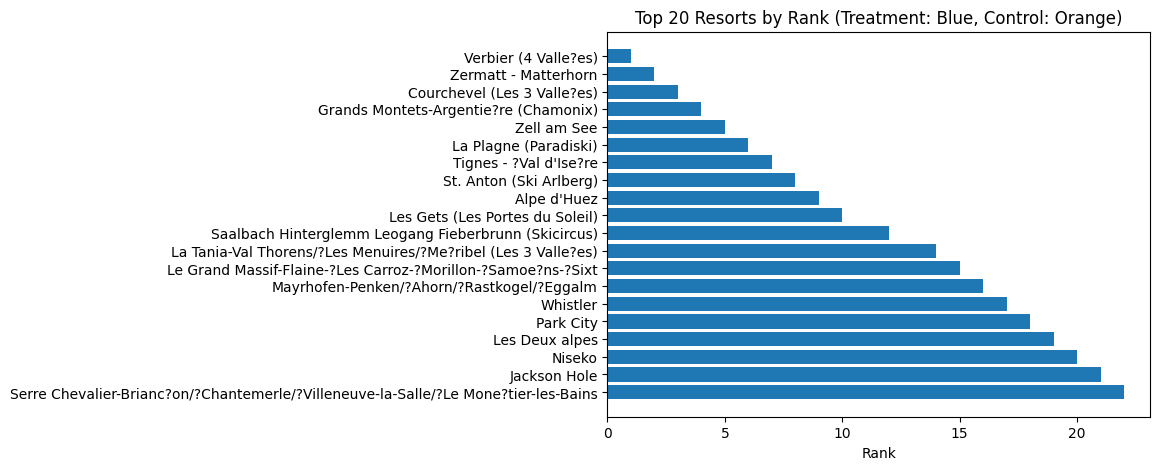

In [30]:
show_the_best(merged, "Rank", ascending = False)

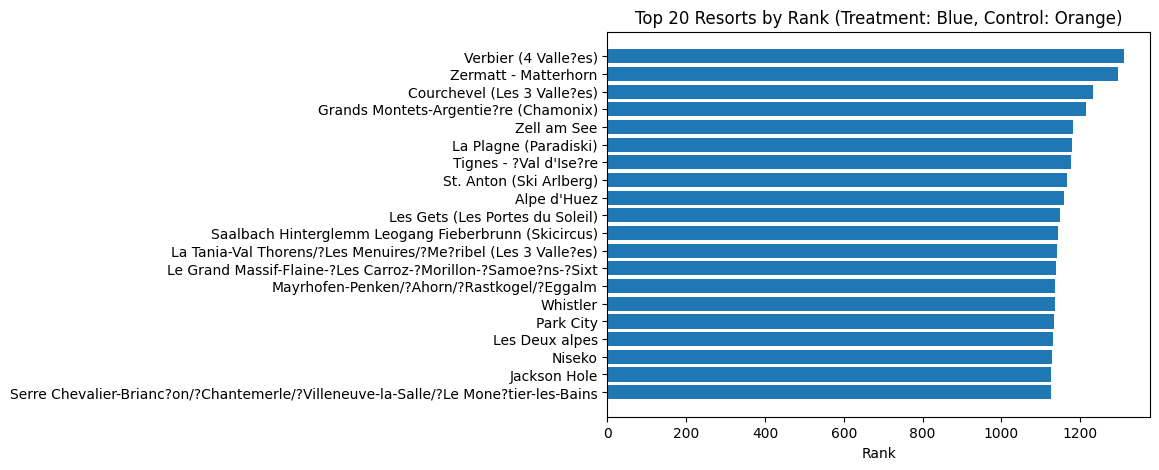

In [31]:
show_the_best(merged, "Rating")

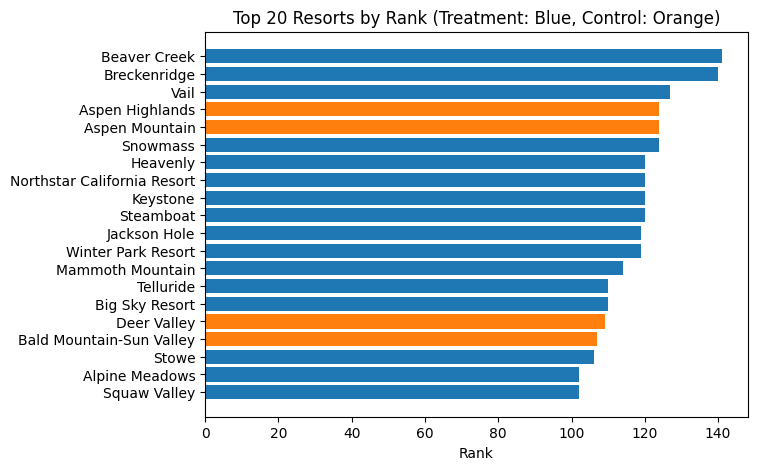

In [32]:
show_the_best(merged, "Price")

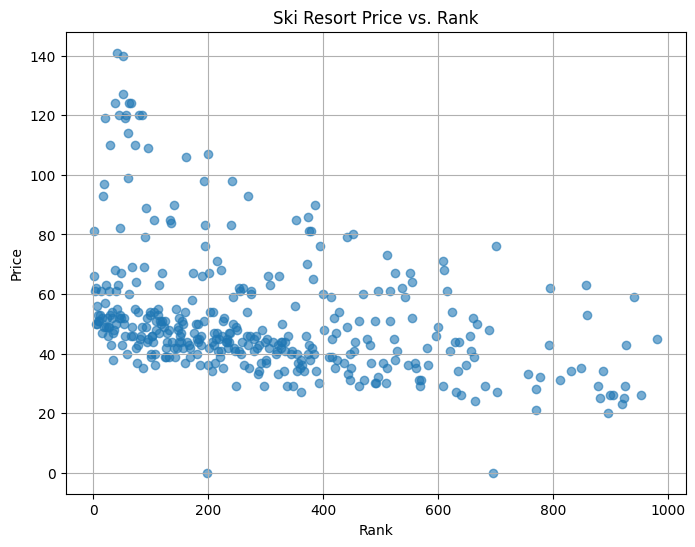

Correlation between Price and rank: -0.379


In [33]:
low_rank_merged = merged[merged['rank'] < 1000] # lower rank better the resort! 
plt.figure(figsize=(8, 6))
plt.scatter(low_rank_merged['rank'], low_rank_merged['Price'], alpha=0.6)
plt.xlabel('Rank')
plt.ylabel('Price')
plt.title('Ski Resort Price vs. Rank')
plt.grid(True)
plt.show()

# Print the correlation between Price and rank
correlation = low_rank_merged['Price'].corr(low_rank_merged['rank'])
print(f"Correlation between Price and rank: {correlation:.3f}")


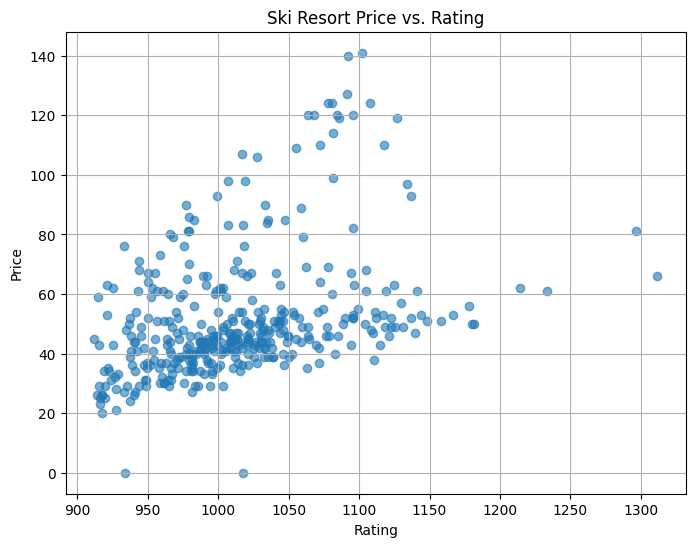

Correlation between Price and Rating: 0.389


In [34]:
low_rank_merged = merged[merged['rank'] < 1000] # lower rank better the resort! 
plt.figure(figsize=(8, 6))
plt.scatter(low_rank_merged['Rating'], low_rank_merged['Price'], alpha=0.6)
plt.xlabel('Rating')
plt.ylabel('Price')
plt.title('Ski Resort Price vs. Rating')
plt.grid(True)
plt.show()

# Print the correlation between Price and rank
correlation = low_rank_merged['Price'].corr(low_rank_merged['Rating'])
print(f"Correlation between Price and Rating: {correlation:.3f}")


In [35]:
# saved merged DF
name = "data/merged_ski_data.csv"
merged.to_csv(name, index=False)

In [36]:
print(merged['rank'].isna().sum())
part_df = merged.dropna(axis=0)  #ski_df #.dropna(axis=0)
print(f"no None merge={len(part_df['ID'])}")
part_df.head(10)

68
no None merge=427


,ID,Resort,Latitude,Longitude,Country,Continent,Price,Season,Highest point,Lowest point,Beginner slopes,Intermediate slopes,Difficult slopes,Total slopes,Longest run,Snow cannons,Surface lifts,Chair lifts,Gondola lifts,Total lifts,Lift capacity,Child friendly,Snowparks,Nightskiing,Summer skiing,Country_numeric,Continent_numeric,Child friendly_numeric,Snowparks_numeric,Nightskiing_numeric,Summer skiing_numeric,Season_numeric,expense_score,key,Rank,Other_name,Rating,rank
0,1,Hemsedal,60.928244,8.383487,Norway,Europe,46,November - May,1450,620,29,10,4,43,6,325,15,6,0,21,22921,Yes,Yes,Yes,No,0,0,1,1,1,0,7,76.0,hemsedal,69.0,Hemsedal,1076.9,69.0
1,2,Geilosiden Geilo,60.534526,8.206372,Norway,Europe,44,November - April,1178,800,18,12,4,34,2,100,18,6,0,24,14225,Yes,Yes,Yes,No,0,0,1,1,1,0,6,76.0,geilosiden geilo,259.0,Geilo,1001.8,259.0
2,3,Golm,47.057810,9.828167,Austria,Europe,48,December - April,2110,650,13,12,1,26,9,123,4,4,3,11,16240,Yes,No,No,No,1,0,1,0,0,0,5,65.1,golm,250.0,Golm,1003.6,250.0
3,4,Red Mountain Resort-Rossland,49.105520,-117.846280,Canada,North America,60,December - April,2075,1185,20,50,50,120,7,0,2,5,1,8,9200,Yes,Yes,Yes,No,2,1,1,1,1,0,5,64.8,red rossland,275.0,Red Mountain Resort,998.0,275.0
4,5,Hafjell,61.230369,10.529014,Norway,Europe,45,November - April,1030,195,33,7,4,44,6,150,14,3,1,18,21060,Yes,Yes,Yes,No,0,0,1,1,1,0,6,76.0,hafjell,219.0,Hafjell,1012.3,219.0
5,6,Voss,60.683706,6.407905,Norway,Europe,43,November - May,960,284,25,4,11,40,0,40,7,4,0,11,11900,Yes,Yes,No,No,0,0,1,1,0,0,7,76.0,voss,288.0,Voss Resort,995.7,288.0
8,9,Hochschwarzeck,47.628373,12.920528,Germany,Europe,22,December - April,1385,1030,4,0,0,4,0,0,3,1,0,4,2880,Yes,No,No,No,5,0,1,0,0,0,5,62.2,hochschwarzeck,1200.0,Hochschwarzeck,899.1,1200.0
9,10,Rossfeld - Berchtesgaden - Oberau,47.651306,13.058977,Germany,Europe,20,December - April,1554,1300,7,1,0,8,6,0,4,0,0,4,3229,Yes,Yes,Yes,No,5,0,1,1,1,0,5,62.2,rossfeld berchtesgaden oberau,1291.0,Rossfeld,893.4,1291.0
10,11,Fernie,49.504175,-115.062867,Canada,North America,67,December - April,2134,1052,42,58,42,142,5,11,3,7,0,10,14514,Yes,Yes,No,No,2,1,1,1,0,0,5,64.8,fernie,120.0,Fernie,1040.9,120.0
11,12,Sun Peaks,50.884468,-119.882329,Canada,North America,62,November - April,2082,1198,13,78,43,134,8,0,6,6,0,12,13895,Yes,Yes,Yes,No,2,1,1,1,1,0,6,64.8,sun peaks,253.0,Sun Peaks,1003.2,253.0


In [37]:
# Rank ATE
print("=== DIAGNOSTIC INFORMATION ===")

# Check the actual values in Snowparks columns
def basic_ATE(df, outcome_col):
    with_sp_data = df[df[T_COL] == 1][outcome_col]
    without_sp_data = df[df[T_COL] == 0][outcome_col]

    print(f"\nNumber of resorts with snowparks (treatment=1): {len(with_sp_data)}")
    print(f"Number of resorts without snowparks (treatment=0): {len(without_sp_data)}")

    if len(with_sp_data) > 0 and len(without_sp_data) > 0: # if somehow one of the groups is emtpy
        with_sp = np.mean(with_sp_data)
        without_sp = np.mean(without_sp_data)
        ate = with_sp - without_sp

        print(f"\nMean {outcome_col} for resorts WITH snowparks: {with_sp:.2f}")
        print(f"Mean {outcome_col} for resorts WITHOUT snowparks: {without_sp:.2f}")
        print(f"Average Treatment Effect (ATE): {ate:.2f}")
        print(f"Percentage Change: {ate/without_sp * 100:.2f}%")
        
        # Interpretation
        if outcome_col.lower() == 'rank':
            if ate < 0:
                print("Interpretation: Having snowparks is associated with BETTER ranking (lower rank number)")
            else:
                print("Interpretation: Having snowparks is associated with WORSE ranking (higher rank number)")
        else:
            if ate > 0:
                print("Interpretation: Having snowparks is associated with BETTER outcomes (higher price or rating)")
            else:
                print("Interpretation: Having snowparks is associated with WORSE outcomes (lower price)")
    else:
        print("\nCannot calculate ATE - missing data in one or both treatment groups")
        if len(with_sp_data) == 0:
            print("No resorts with snowparks found in the dataset")
        if len(without_sp_data) == 0:
            print("No resorts without snowparks found in the dataset")

basic_ATE(part_df, 'rank')

=== DIAGNOSTIC INFORMATION ===

Number of resorts with snowparks (treatment=1): 333
Number of resorts without snowparks (treatment=0): 94

Mean rank for resorts WITH snowparks: 422.37
Mean rank for resorts WITHOUT snowparks: 705.02
Average Treatment Effect (ATE): -282.65
Percentage Change: -40.09%
Interpretation: Having snowparks is associated with BETTER ranking (lower rank number)


basic_ATE(part_df, "Rating")

In [38]:
basic_ATE(part_df, "Rating")


Number of resorts with snowparks (treatment=1): 333
Number of resorts without snowparks (treatment=0): 94

Mean Rating for resorts WITH snowparks: 1007.92
Mean Rating for resorts WITHOUT snowparks: 960.01
Average Treatment Effect (ATE): 47.91
Percentage Change: 4.99%
Interpretation: Having snowparks is associated with BETTER outcomes (higher price or rating)


Price ATE

In [39]:
basic_ATE(part_df, 'Price')


Number of resorts with snowparks (treatment=1): 333
Number of resorts without snowparks (treatment=0): 94

Mean Price for resorts WITH snowparks: 52.68
Mean Price for resorts WITHOUT snowparks: 42.69
Average Treatment Effect (ATE): 9.99
Percentage Change: 23.40%
Interpretation: Having snowparks is associated with BETTER outcomes (higher price or rating)


## EDA

NOTE: we use separate datasets depending on the chosen ouctome column (for checkups we did ranks and rating), because we can't impute missing values for outcome column.
We will do it later, when running estimators (impute values in Rating column) - and in addition check for robustness with different imputation methods

In the end we have these datasets: 

- `merged` - contains nulls in ratings and rankings columns
- `merged_clean` - no nulls (by removing rows with missing  matches)
- `ski_df` 

In [40]:
target = 'Price'

if target == 'Rank' or target == 'Rating':
    df = merged_clean.copy()
else:
    df = merged.copy()
    
# This code is from later part, but we used it here for statistic dignostic
switzerland_score = costs_df.loc[costs_df['Country'] == 'Switzerland', 'Cost of Living Index'].values[0]
df.loc[df['Country'] == 'Liechtenstein', 'expense_score'] = switzerland_score
bosnia_score = costs_df.loc[costs_df['Country'] == 'Bosnia And Herzegovina', 'Cost of Living Index'].values[0]
df.loc[df['Country'] == 'Bosnia and Herzegovina', 'expense_score'] = bosnia_score
france_score = costs_df.loc[costs_df['Country'] == 'France', 'Cost of Living Index'].values[0]
df.loc[df['Country'] == 'Andorra', 'expense_score'] = france_score
# filling temmporaly the Ratings column
features = ['expense_score', 'Season_numeric', 'Longest run', 'Highest point', 'Lowest point', 
            'Continent_numeric', 'Beginner slopes', 'Intermediate slopes', 'Difficult slopes']

# Using rows with no missing values in features and Rating
df_complete = df.dropna(subset=features + ['Rating']).copy()
df_missing = df[df['Rating'].isna()].copy()

nn = NearestNeighbors(n_neighbors=5, metric='euclidean') # Robustness try to change metric!
nn.fit(df_complete[features])

for idx, row in df_missing.iterrows():
    X = row[features].values.reshape(1, -1)
    distances, indices = nn.kneighbors(X)
    neighbor_ratings = df_complete.iloc[indices[0]]['Rating']
    df.at[idx, 'Rating'] = neighbor_ratings.mean()
    

numeric_cols = df.select_dtypes(include=[np.number]).columns
confounders = [col for col in numeric_cols if col not in ['Price', 'Rank', 'rank', 'ID', 'Snowparks_numeric', 'Resort_numeric','Rating']]
X = df[confounders]

# filtering only on condounders and target (possible ouctome)
y = df[target] 
X = df[confounders]
T = df[T_COL]
X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(X, T, y, test_size=0.2, random_state=42)
confounders

['Latitude',
 'Longitude',
 'Highest point',
 'Lowest point',
 'Beginner slopes',
 'Intermediate slopes',
 'Difficult slopes',
 'Total slopes',
 'Longest run',
 'Snow cannons',
 'Surface lifts',
 'Chair lifts',
 'Gondola lifts',
 'Total lifts',
 'Lift capacity',
 'Country_numeric',
 'Continent_numeric',
 'Child friendly_numeric',
 'Nightskiing_numeric',
 'Summer skiing_numeric',
 'Season_numeric',
 'expense_score']

In [41]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
print("Linear Regression Train R^2:", lr_reg.score(X_train, y_train))
print("Linear Regression Test R^2:", lr_reg.score(X_test, y_test))


rf = RandomForestRegressor(
    n_estimators=50,        # fewer trees
    max_depth=4,            # limit tree depth
    min_samples_leaf=10,    # require more samples per leaf
    random_state=42
)
rf.fit(X_train, y_train)
print("Random Forest Train R^2:", rf.score(X_train, y_train))
print("Random Forest Test R^2:", rf.score(X_test, y_test))


xgb = XGBRegressor(
    n_estimators=50,        # fewer boosting rounds
    max_depth=3,            # shallower trees
    min_child_weight=10,    # require more samples per leaf
    subsample=0.7,          # use a fraction of data for each tree
    colsample_bytree=0.7,   # use a fraction of features for each tree
    random_state=42
)
xgb.fit(X_train, y_train)
print("XGBoost Train R^2:", xgb.score(X_train, y_train))
print("XGBoost Test R^2:", xgb.score(X_test, y_test))


# Evaluation of all models
y_pred_lr = lr_reg.predict(X_test)
print("Linear Regression Metrics:")
print("  R^2:", r2_score(y_test, y_pred_lr))
print("  MSE:", mean_squared_error(y_test, y_pred_lr))
print("  MAE:", mean_absolute_error(y_test, y_pred_lr))

y_pred_rf = rf.predict(X_test)
print("\nRandom Forest Metrics:")
print("  R^2:", r2_score(y_test, y_pred_rf))
print("  MSE:", mean_squared_error(y_test, y_pred_rf))
print("  MAE:", mean_absolute_error(y_test, y_pred_rf))

y_pred_xgb = xgb.predict(X_test)
print("\nXGBoost Metrics:")
print("  R^2:", r2_score(y_test, y_pred_xgb))
print("  MSE:", mean_squared_error(y_test, y_pred_xgb))
print("  MAE:", mean_absolute_error(y_test, y_pred_xgb))



Linear Regression Train R^2: 0.6360464548373043
Linear Regression Test R^2: 0.5872342450002757
Random Forest Train R^2: 0.8067210786087257
Random Forest Test R^2: 0.7142999764545325
XGBoost Train R^2: 0.9452277421951294
XGBoost Test R^2: 0.6457927227020264
Linear Regression Metrics:
  R^2: 0.5872342450002757
  MSE: 190.940278690935
  MAE: 9.39812047275433

Random Forest Metrics:
  R^2: 0.7142999764545325
  MSE: 132.16125964183897
  MAE: 7.370359882438765

XGBoost Metrics:
  R^2: 0.6457927227020264
  MSE: 163.85183715820312
  MAE: 7.133893966674805


Top features by importance (Random Forest):
Longitude: 0.486
expense_score: 0.106
Lift capacity: 0.097
Intermediate slopes: 0.075
Lowest point: 0.037
Latitude: 0.036
Country_numeric: 0.033
Total slopes: 0.029
Total lifts: 0.021
Highest point: 0.020


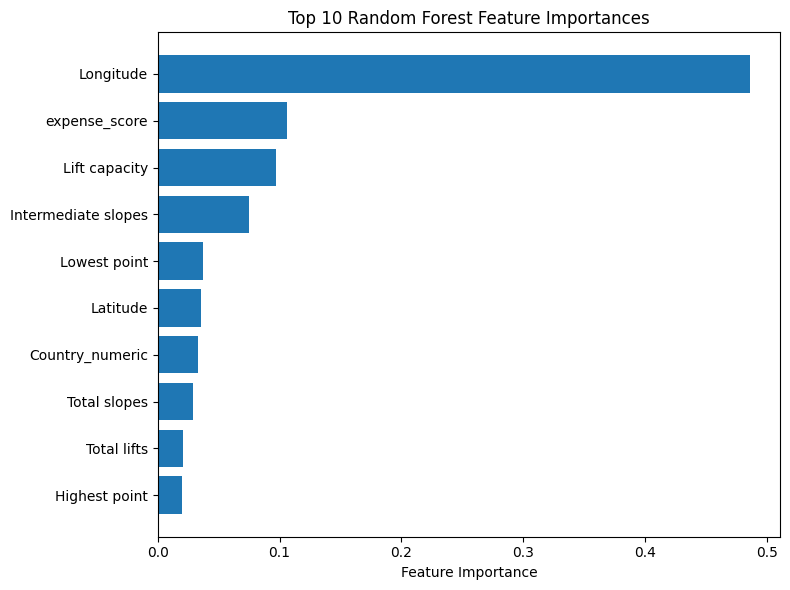

In [42]:
# Show the most important features for the Random Forest model (rf)
importances_target = rf.feature_importances_
feature_names = X_train.columns

# Sort features by importance
sorted_idx = importances_target.argsort()[::-1]
target_importances_features_names = feature_names[sorted_idx[:10]]
print("Top features by importance (Random Forest):")
for i in sorted_idx[:10]:
    print(f"{feature_names[i]}: {importances_target[i]:.3f}")
plt.figure(figsize=(8, 6))
plt.barh([feature_names[i] for i in sorted_idx[:10]], importances_target[sorted_idx[:10]])
plt.xlabel("Feature Importance")
plt.title("Top 10 Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()  

Top features by importance (XGB Regressor):
expense_score: 0.174
Summer skiing_numeric: 0.123
Total slopes: 0.111
Intermediate slopes: 0.093
Longitude: 0.080
Country_numeric: 0.077
Lift capacity: 0.049
Longest run: 0.037
Chair lifts: 0.036
Lowest point: 0.030


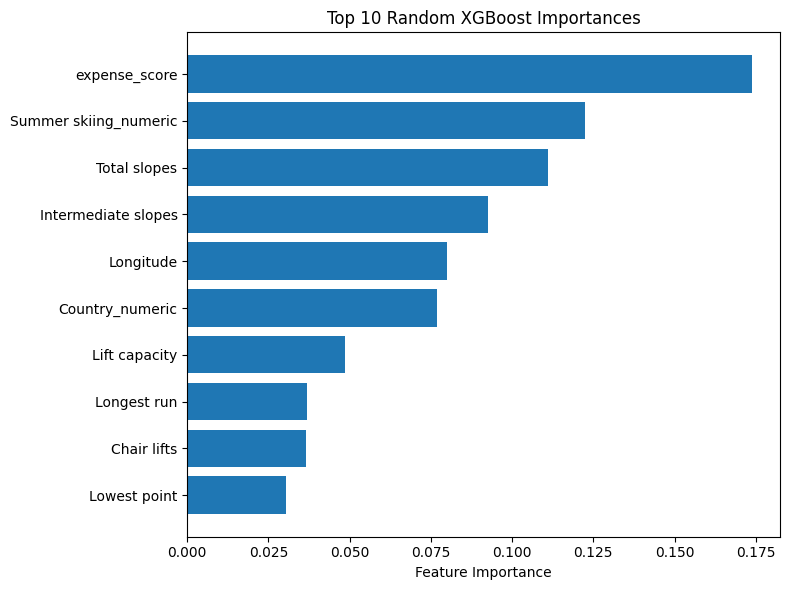

In [43]:
# Show the most important features for the Random Forest model (rf)
importances_target = xgb.feature_importances_
feature_names = X_train.columns

# Sort features by importance
sorted_idx = importances_target.argsort()[::-1]
target_importances_features_names = feature_names[sorted_idx[:10]]
print("Top features by importance (XGB Regressor):")
for i in sorted_idx[:10]:
    print(f"{feature_names[i]}: {importances_target[i]:.3f}")
plt.figure(figsize=(8, 6))
plt.barh([feature_names[i] for i in sorted_idx[:10]], importances_target[sorted_idx[:10]])
plt.xlabel("Feature Importance")
plt.title("Top 10 Random XGBoost Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()  

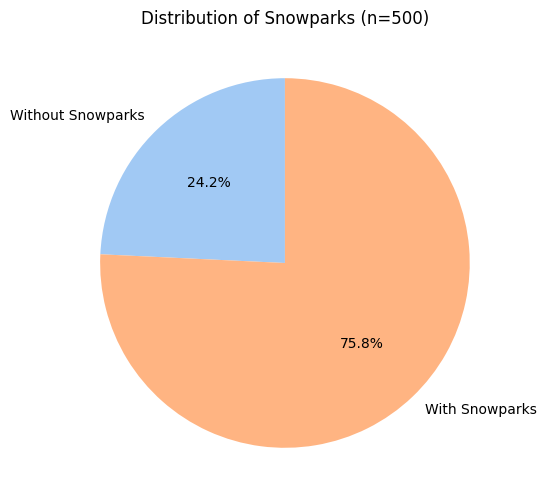

In [44]:
column  = "Snowparks_numeric" # "Snowparks"
# Count the occurrences for each value in the column
counts = ski_df[column].value_counts().sort_index()
labels_names = {1: 'With Snowparks', 0: 'Without Snowparks'}
labels = [labels_names[val] for val in counts.index]

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
plt.title(f"Distribution of Snowparks (n=500)")
plt.show()



In [45]:
ski_df.columns

Index(['ID', 'Resort', 'Latitude', 'Longitude', 'Country', 'Continent',
       'Price', 'Season', 'Highest point', 'Lowest point', 'Beginner slopes',
       'Intermediate slopes', 'Difficult slopes', 'Total slopes',
       'Longest run', 'Snow cannons', 'Surface lifts', 'Chair lifts',
       'Gondola lifts', 'Total lifts', 'Lift capacity', 'Child friendly',
       'Snowparks', 'Nightskiing', 'Summer skiing', 'Country_numeric',
       'Continent_numeric', 'Child friendly_numeric', 'Snowparks_numeric',
       'Nightskiing_numeric', 'Summer skiing_numeric', 'Season_numeric',
       'expense_score', 'key', 'Rank', 'Other_name', 'Rating'],
      dtype='object')

Grouping the countries to continents

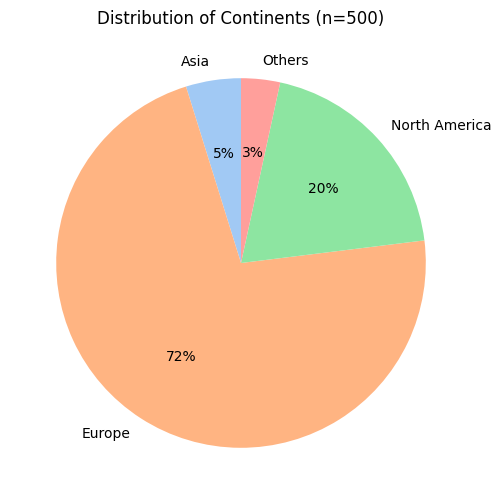

In [46]:
column  = "Continent" # "Snowparks"

# Count the occurrences for each value in the column
counts = ski_df[column].value_counts().sort_index()
# If a continent has less than 5% of the resorts, group it as 'Others'
threshold = 0.04 * counts.sum()
counts_grouped = counts.copy()
low_count_labels = counts[counts < threshold].index
counts_grouped['Others'] = counts_grouped[low_count_labels].sum()
counts_grouped = counts_grouped.drop(low_count_labels)
labels = [val for val in counts_grouped.index]
counts = counts_grouped
# labels_names = {1: 'With Snowparks', 0: 'Without Snowparks'}
labels = [val for val in counts.index]

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.0f%%', startangle=90, colors=sns.color_palette("pastel"))
plt.title(f"Distribution of Continents (n=500)")
plt.show()

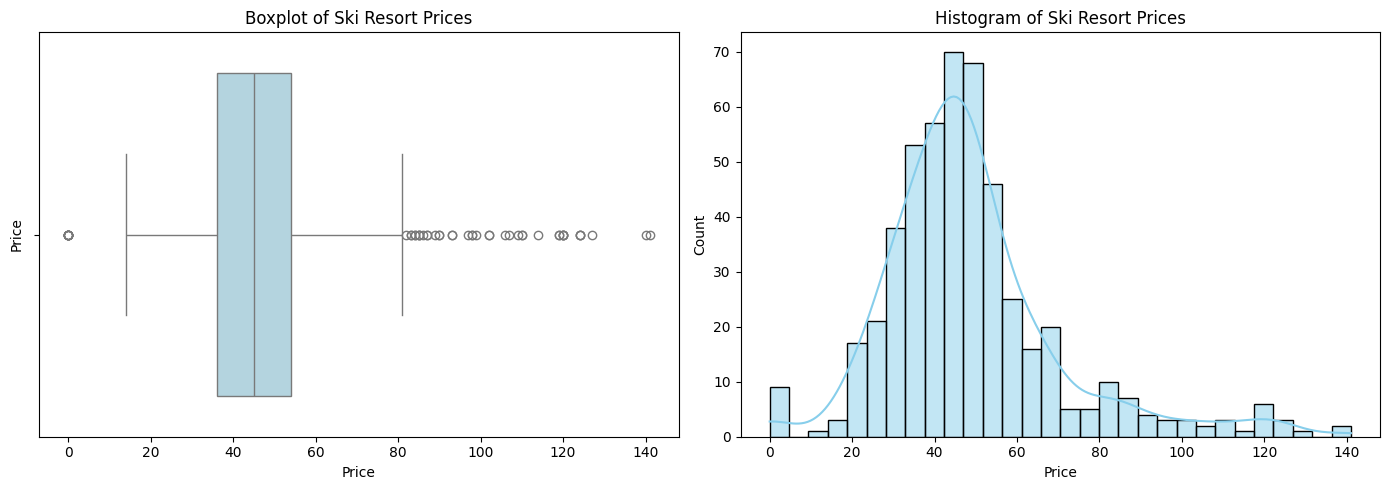

In [47]:
# Show boxplot and histplot for Price side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot
sns.boxplot(x=ski_df['Price'], ax=axes[0], color='lightblue')
axes[0].set_title('Boxplot of Ski Resort Prices')
axes[0].set_ylabel('Price')

# Histplot
sns.histplot(ski_df['Price'], bins=30, kde=True, color='skyblue', ax=axes[1])
axes[1].set_title('Histogram of Ski Resort Prices')
axes[1].set_xlabel('Price')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

## Correlation

In [48]:
mean_price_snowparks_0 = ski_df[ski_df["Snowparks_numeric"] == 0]["Rank"].mean()
mean_price_snowparks_1 = ski_df[ski_df["Snowparks_numeric"] == 1]["Rank"].mean()
print("Mean rank for Snowparks = 0:", round(mean_price_snowparks_0, 2))
print("Mean rank for Snowparks = 1:", round(mean_price_snowparks_1, 2))

Mean rank for Snowparks = 0: 705.02
Mean rank for Snowparks = 1: 428.58


In [49]:
mean_price_snowparks_0 = ski_df[ski_df["Snowparks_numeric"] == 0][Y_COL].mean()
mean_price_snowparks_1 = ski_df[ski_df["Snowparks_numeric"] == 1][Y_COL].mean()
print("Mean Price for Snowparks = 0:", round(mean_price_snowparks_0, 2))
print("Mean Price for Snowparks = 1:", round(mean_price_snowparks_1, 2))

Mean Price for Snowparks = 0: 40.39
Mean Price for Snowparks = 1: 51.39


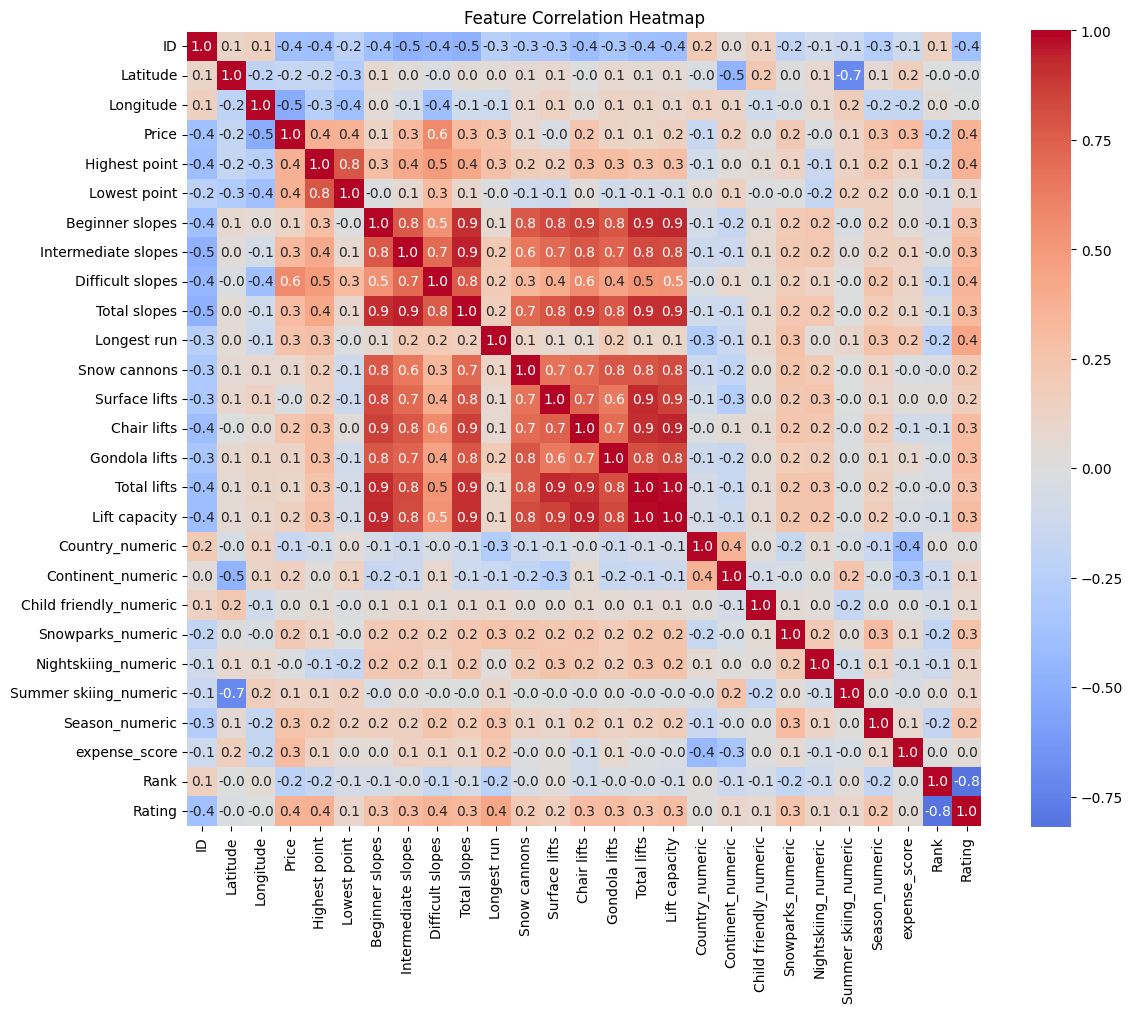

In [50]:
correlation_matrix = ski_df.select_dtypes(include=['float64', 'int64']).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.1f', square=True)

plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

## Data cleaning

### Robustness

Uncomment these rows to run robustness checks we did (comment other parts that clean data differently)

In [51]:
# merged['Rating'] = merged['Rating'].fillna(new_merged['Rating'].mean())   

### Fixing missing values

In [52]:
merged[merged.columns[merged.isna().any()]].isna().sum()

expense_score     7
Rank             68
Other_name       68
Rating           68
rank             68
dtype: int64

In [53]:
merged[merged['expense_score'].isna()]['Country']

40                    Andorra
79                    Andorra
84                    Andorra
155                   Andorra
274                   Andorra
357    Bosnia and Herzegovina
418             Liechtenstein
Name: Country, dtype: object

Bosnia and Herzegovina is 'Bosnia And Herzegovina' in costs_df.

From research andorra is similiar to France, and Liechtenstein to Switzerland 

In [54]:
switzerland_score = costs_df.loc[costs_df['Country'] == 'Switzerland', 'Cost of Living Index'].values[0]
merged.loc[merged['Country'] == 'Liechtenstein', 'expense_score'] = switzerland_score

bosnia_score = costs_df.loc[costs_df['Country'] == 'Bosnia And Herzegovina', 'Cost of Living Index'].values[0]
merged.loc[merged['Country'] == 'Bosnia and Herzegovina', 'expense_score'] = bosnia_score

france_score = costs_df.loc[costs_df['Country'] == 'France', 'Cost of Living Index'].values[0]
merged.loc[merged['Country'] == 'Andorra', 'expense_score'] = france_score

To fill rating we will use nearest neighbours as it's more specific. 
Using mean can create bias.

In [55]:
features = ['expense_score', 'Season_numeric', 'Longest run', 'Highest point', 'Lowest point', 
            'Continent_numeric', 'Beginner slopes', 'Intermediate slopes', 'Difficult slopes']

# Using rows with no missing values in features and Rating
df_complete = merged.dropna(subset=features + ['Rating']).copy()
df_missing = merged[merged['Rating'].isna()].copy()

nn = NearestNeighbors(n_neighbors=5, metric='euclidean')
nn.fit(df_complete[features])

for idx, row in df_missing.iterrows():
    X = row[features].values.reshape(1, -1)
    distances, indices = nn.kneighbors(X)
    neighbor_ratings = df_complete.iloc[indices[0]]['Rating']
    merged.at[idx, 'Rating'] = neighbor_ratings.mean()

In [56]:
# Last check
merged[merged.columns[merged.isna().any()]].isna().sum()

Rank          68
Other_name    68
rank          68
dtype: int64

### Outliers

We added robustness checks here as well - using standard IQR based technique of removing samples (Fences)

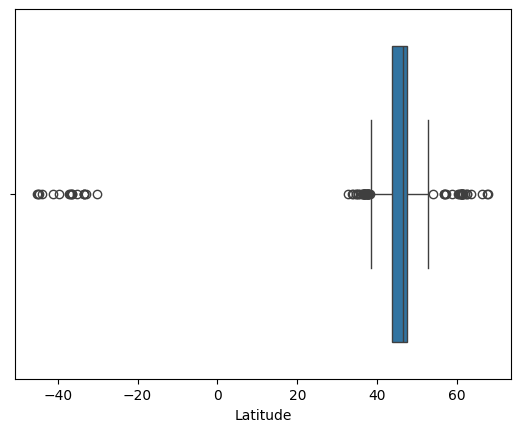

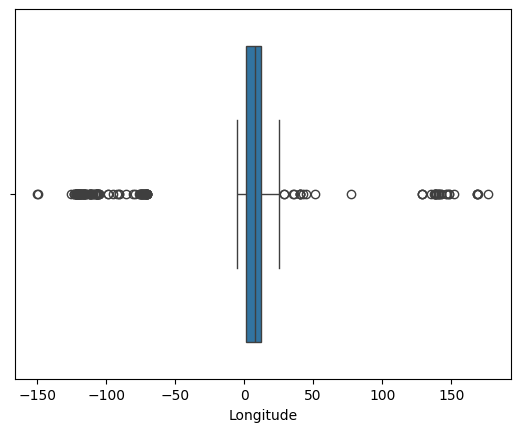

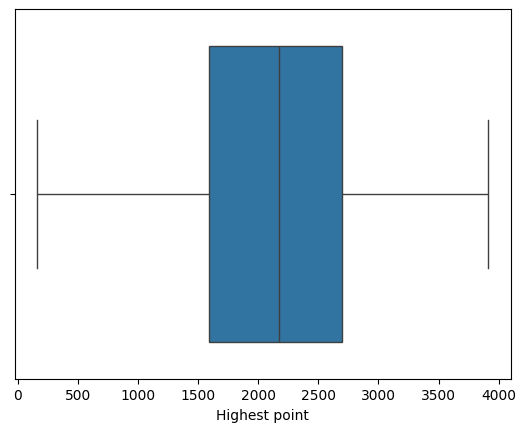

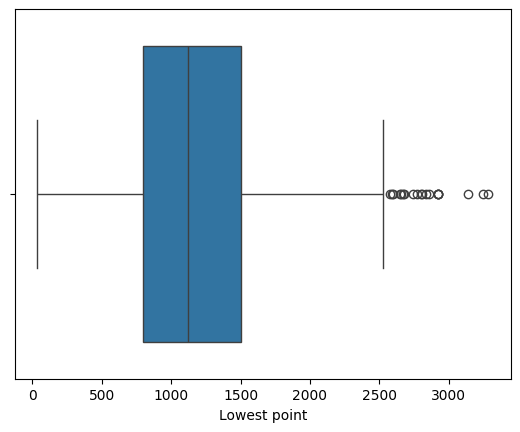

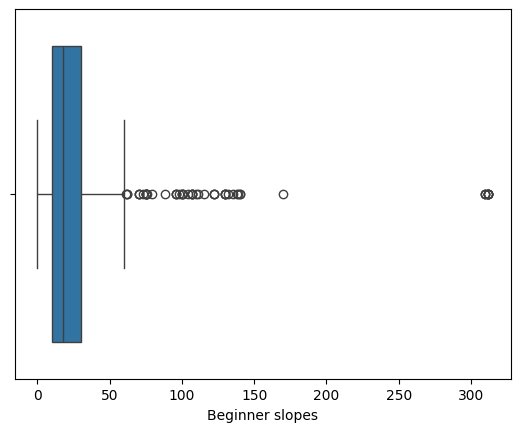

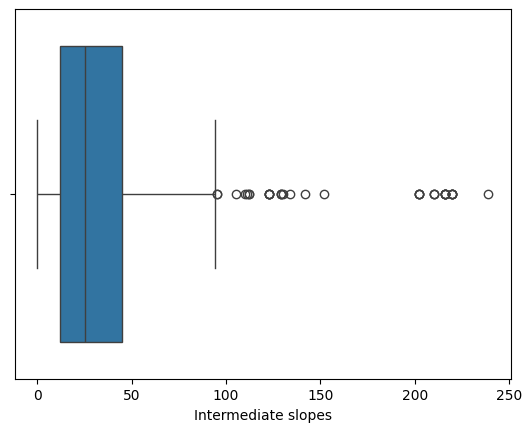

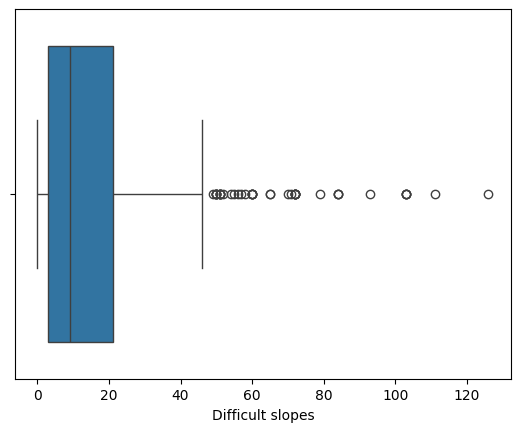

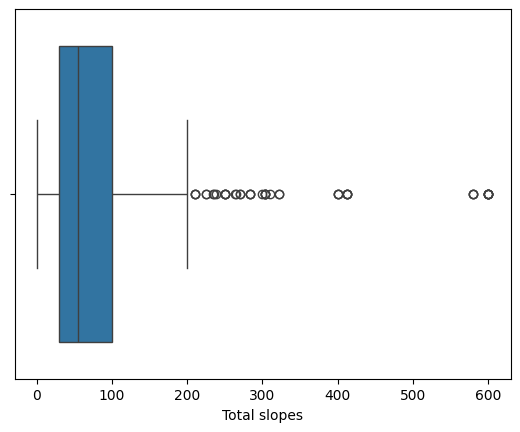

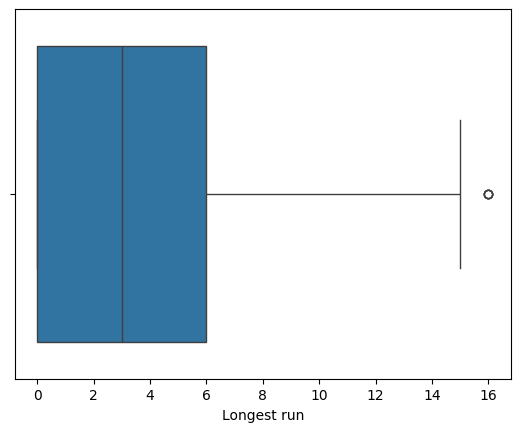

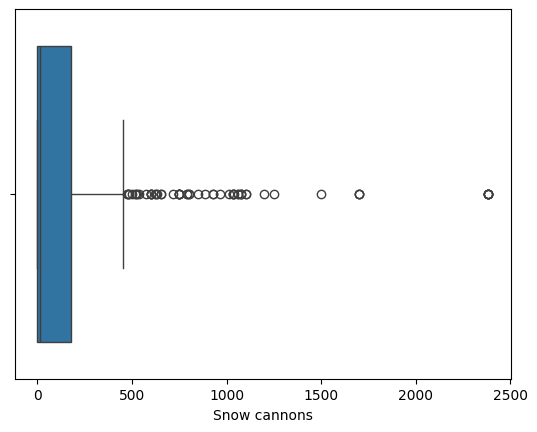

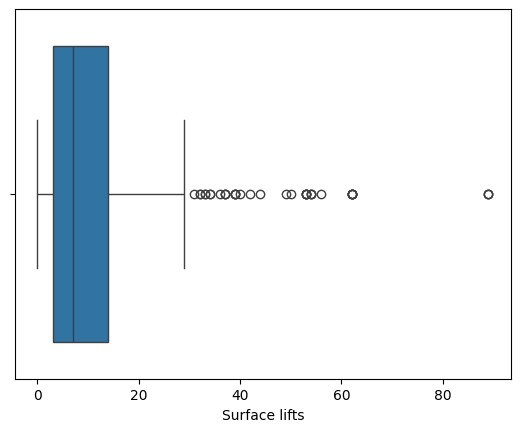

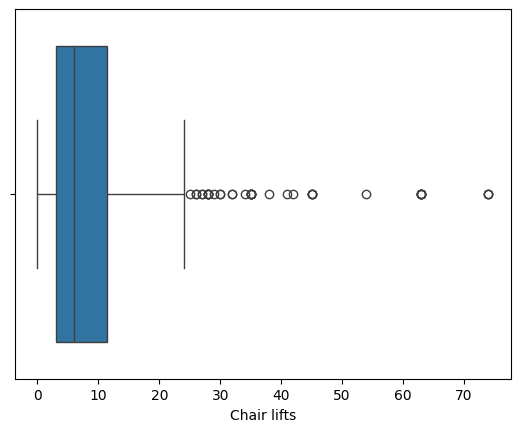

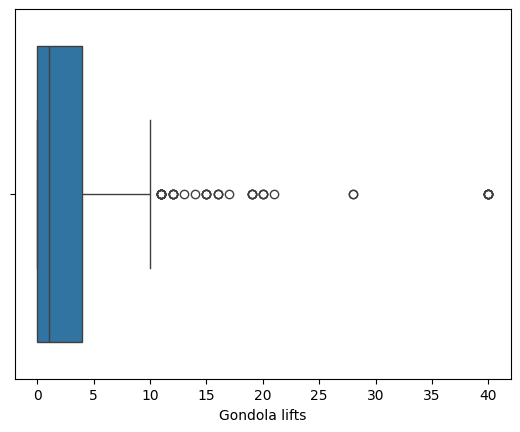

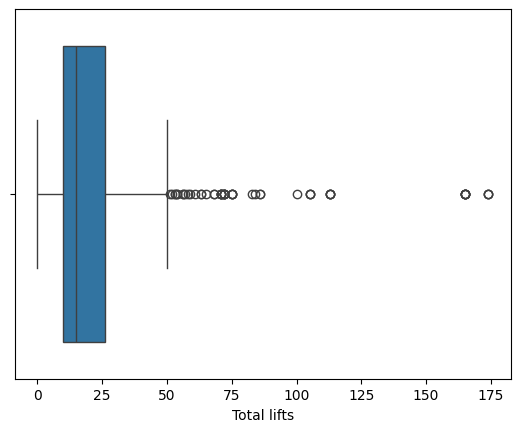

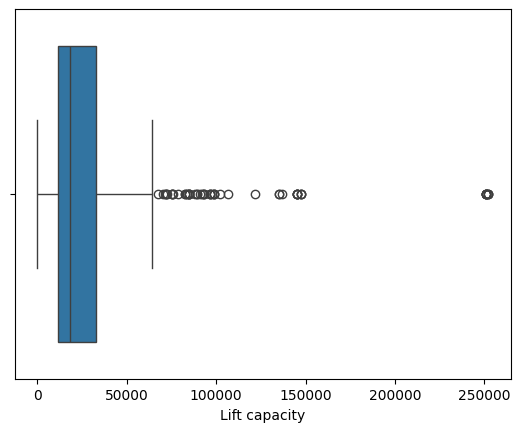

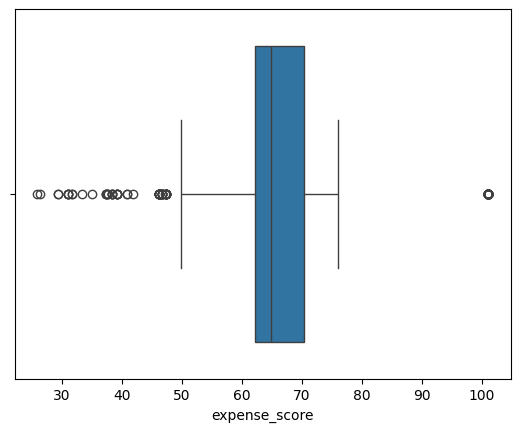

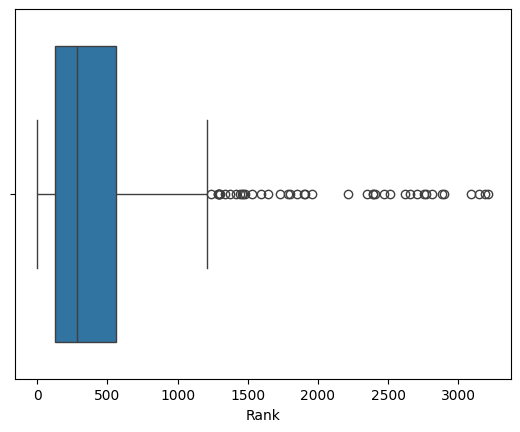

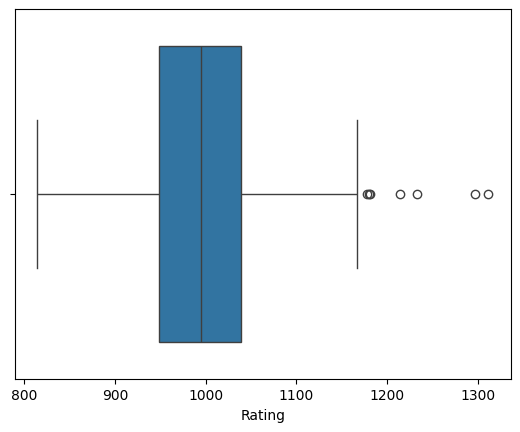

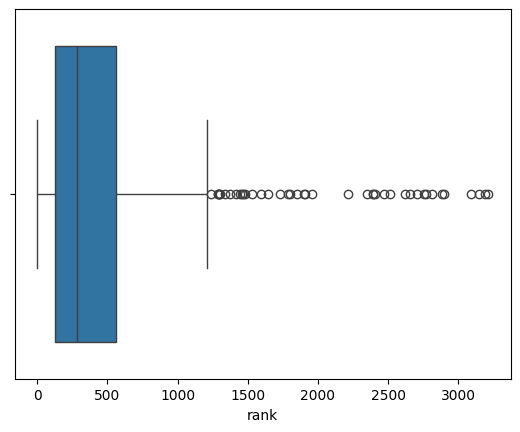

In [57]:
numrical = ['Latitude',
 'Longitude',
 'Highest point',
 'Lowest point',
 'Beginner slopes',
 'Intermediate slopes',
 'Difficult slopes',
 'Total slopes',
 'Longest run',
 'Snow cannons',
 'Surface lifts',
 'Chair lifts',
 'Gondola lifts',
 'Total lifts',
 'Lift capacity',
 'expense_score',
 'Rank',
 'Rating',
 'rank']


for col in numrical:
    sns.boxplot(x=merged[col])
    plt.show()

Prices that have zero - clearly an error, in addition we clwan some extreme prices as well: 

In [58]:
def remove_outliers_iqr(df, column, k=1.5):
    """
    Remove outliers from a DataFrame column using the IQR method.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [59]:
if ROBUSTNESS: 
    for col in ['Total slopes', 'Price', 'expense_score','Lift capacity']:
        merged = remove_outliers_iqr(merged, col)
else: 
    merged = merged.drop(merged[merged['Price'] == 0].index)
    merged = merged.drop(merged[merged['Price']>=140].index)
    merged = merged.reset_index().drop(columns='index')

merged

,ID,Resort,Latitude,Longitude,Country,Continent,Price,Season,Highest point,Lowest point,Beginner slopes,Intermediate slopes,Difficult slopes,Total slopes,Longest run,Snow cannons,Surface lifts,Chair lifts,Gondola lifts,Total lifts,Lift capacity,Child friendly,Snowparks,Nightskiing,Summer skiing,Country_numeric,Continent_numeric,Child friendly_numeric,Snowparks_numeric,Nightskiing_numeric,Summer skiing_numeric,Season_numeric,expense_score,key,Rank,Other_name,Rating,rank
0,1,Hemsedal,60.928244,8.383487,Norway,Europe,46,November - May,1450,620,29,10,4,43,6,325,15,6,0,21,22921,Yes,Yes,Yes,No,0,0,1,1,1,0,7,76.0,hemsedal,69.0,Hemsedal,1076.9,69.0
1,2,Geilosiden Geilo,60.534526,8.206372,Norway,Europe,44,November - April,1178,800,18,12,4,34,2,100,18,6,0,24,14225,Yes,Yes,Yes,No,0,0,1,1,1,0,6,76.0,geilosiden geilo,259.0,Geilo,1001.8,259.0
2,3,Golm,47.057810,9.828167,Austria,Europe,48,December - April,2110,650,13,12,1,26,9,123,4,4,3,11,16240,Yes,No,No,No,1,0,1,0,0,0,5,65.1,golm,250.0,Golm,1003.6,250.0
3,4,Red Mountain Resort-Rossland,49.105520,-117.846280,Canada,North America,60,December - April,2075,1185,20,50,50,120,7,0,2,5,1,8,9200,Yes,Yes,Yes,No,2,1,1,1,1,0,5,64.8,red rossland,275.0,Red Mountain Resort,998.0,275.0
4,5,Hafjell,61.230369,10.529014,Norway,Europe,45,November - April,1030,195,33,7,4,44,6,150,14,3,1,18,21060,Yes,Yes,Yes,No,0,0,1,1,1,0,6,76.0,hafjell,219.0,Hafjell,1012.3,219.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,494,Gra?chen,46.196018,7.842161,Switzerland,Europe,48,December - April,2864,1619,9,31,2,42,7,0,9,5,1,15,13860,Yes,No,No,No,6,0,1,0,0,0,5,101.1,gra chen,1849.0,Chapeau Râblé,867.7,1849.0
484,496,Kranzberg-Mittenwald,47.451359,11.228630,Germany,Europe,29,December,1350,980,6,7,2,15,2,8,9,1,0,10,5850,Yes,Yes,Yes,No,5,0,1,1,1,0,1,62.2,kranzberg mittenwald,568.0,Kranzberg,948.6,568.0
485,497,Wetterstein lifts-Wettersteinbahnen- Ehrwald,47.406897,10.927998,Austria,Europe,43,December - March,1530,1000,15,5,3,23,3,33,6,4,0,10,5425,Yes,Yes,No,No,1,0,1,1,0,0,4,65.1,wetterstein lifts wettersteinbahnen ehrwald,481.0,Ehrwalder Wettersteinbahnen,963.5,481.0
486,498,Stuhleck-Spital am Semmering,47.574195,15.789964,Austria,Europe,42,April,1774,777,18,6,0,24,0,240,7,2,0,9,14400,Yes,Yes,Yes,No,1,0,1,1,1,0,1,65.1,stuhleck spital am semmering,306.0,Stuhleck,991.5,306.0


### Scaling - used in robustness

Without scaling in Linear Regression coefficients depend on the units of the features.

for example if we measure height in cm vs m, the coefficient changes by a factor of 100.

we want all features to be on a comparable scale, so coefficients reflect their relative importance rather than unit differences.

In [60]:
# if ROBUSTNESS: 
#     scaler = StandardScaler()
#     df_scaled = pd.DataFrame(
#         scaler.fit_transform(merged[numrical]),
#         columns=numrical
#     )
#     merged[numrical] = df_scaled[numrical]
#     merged

# Causal Assumptions

## SUTVA

We used direct estimation solely for diagnostic pruposes!

In [361]:
R = 6371  # Earth radius km
coords = np.radians(ski_df[['Latitude','Longitude']].to_numpy())
D = pairwise .haversine_distances(coords, coords) * R

# neighbors within 100km
adj = (D <= 100) & (D > 0) # D>0 exculdes the resort itself

neighbor_treated_cnt = adj.dot(ski_df['Snowparks_numeric'].to_numpy())
neighbor_cnt = adj.sum(axis=1)
ski_df['neighbor_treated_share'] = np.where(neighbor_cnt>0, neighbor_treated_cnt/neighbor_cnt, 0.0)

X = ski_df[['Snowparks_numeric','neighbor_treated_share']] 
X = sm.add_constant(X)
model = sm.OLS(ski_df['Price'], X, missing='drop').fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     13.74
Date:                Thu, 04 Sep 2025   Prob (F-statistic):           1.56e-06
Time:                        20:25:37   Log-Likelihood:                -2230.1
No. Observations:                 499   AIC:                             4466.
Df Residuals:                     496   BIC:                             4479.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     43

In [362]:
X = ski_df[['Snowparks_numeric','neighbor_treated_share', 'expense_score', 'Season_numeric', 'Longest run','Highest point','Lowest point','Continent_numeric','Beginner slopes','Intermediate slopes','Difficult slopes']] 
X = sm.add_constant(X)
model = sm.OLS(ski_df['Price'], X, missing='drop').fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     46.41
Date:                Thu, 04 Sep 2025   Prob (F-statistic):           1.63e-68
Time:                        20:25:37   Log-Likelihood:                -2036.1
No. Observations:                 492   AIC:                             4096.
Df Residuals:                     480   BIC:                             4147.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      3

## Overlap (Common support)

In [390]:
confounders = ['Intermediate slopes', 'Longitude', 'Summer skiing_numeric', 'Lowest point', 'Chair lifts', 'Lift capacity', 'Total slopes', 'Highest point', 'Country_numeric', 'expense_score']

y = df[Y_COL] 
X = df[confounders]
T = df[T_COL]
X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(X, T, y, test_size=0.2, random_state=71) 

propensity_model = LogisticRegressionCV(cv=5, random_state=42)
propensity_model.fit(X_train, T_train)
# Predict probabilities on the test set
T_prob_train = propensity_model.predict_proba(X_train)[:,1]
T_prob_test = propensity_model.predict_proba(X_test)[:,1] # Probabilities for the positive class


In [372]:
# Brier score, 0 is the perfect score
brier_score = brier_score_loss(T_test, T_prob_test)
print(f'Brier Score: {brier_score}')

Brier Score: 0.1450323888262486


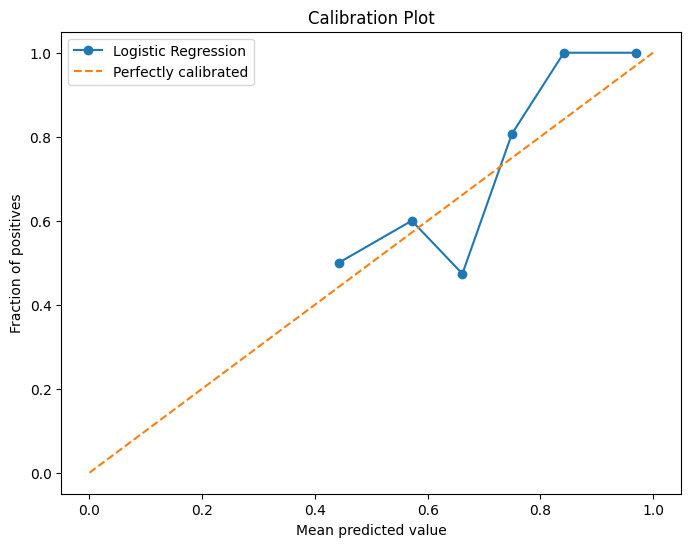

In [373]:
# Calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(T_test, T_prob_test, n_bins=10)

# Plot the calibration curve
plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.title('Calibration Plot')
plt.legend()
plt.show()

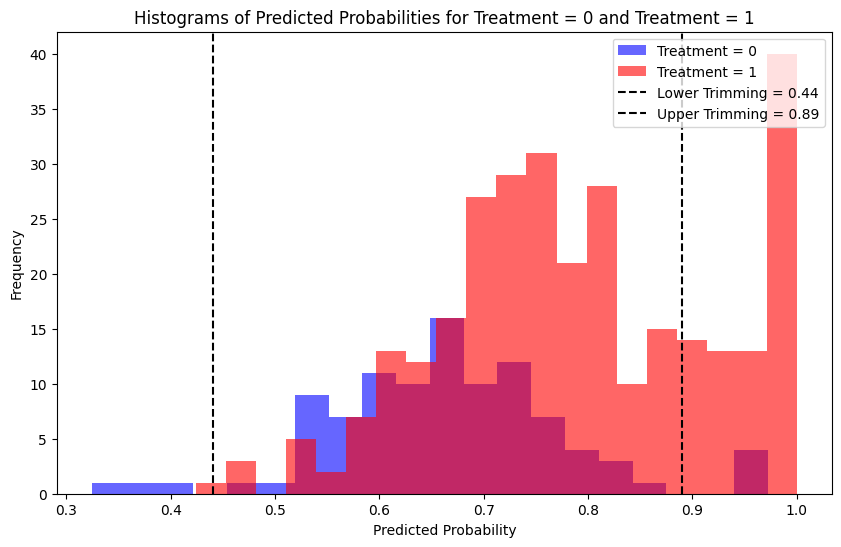

In [391]:
prob_treatment_0 = T_prob_train[T_train == 0]
prob_treatment_1 = T_prob_train[T_train == 1]

plt.figure(figsize=(10, 6))
plt.hist(prob_treatment_0, bins=20, alpha=0.6, label='Treatment = 0', color='blue')
plt.hist(prob_treatment_1, bins=20, alpha=0.6, label='Treatment = 1', color='red')
plt.axvline(x=0.44, color='black', linestyle='--', label='Lower Trimming = 0.44')
plt.axvline(x=0.89, color='black', linestyle='--', label='Upper Trimming = 0.89')

plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Histograms of Predicted Probabilities for Treatment = 0 and Treatment = 1')
plt.legend(loc='upper right')
plt.show()

In [392]:
low_lim = 0.44
up_lim = 0.89
print('Participants removed from train set due to lack of lower overlap: {}'.format(X_train[T_prob_train < low_lim].shape[0]))
print('Participants removed from train set due to lack of upper overlap: {}'.format(X_train[T_prob_train > up_lim].shape[0]))
print('Participants removed from test set due to lack of lower overlap: {}'.format(X_test[T_prob_test < low_lim].shape[0]))
print('Participants removed from train set due to lack of upper overlap: {}'.format(X_test[T_prob_test > up_lim].shape[0]))

Participants removed from train set due to lack of lower overlap: 4
Participants removed from train set due to lack of upper overlap: 81
Participants removed from test set due to lack of lower overlap: 2
Participants removed from train set due to lack of upper overlap: 19


In [393]:
X_train = X_train[(T_prob_train >= low_lim) & (T_prob_train <= up_lim)]
T_train = T_train[(T_prob_train >= low_lim) & (T_prob_train <= up_lim)]
y_train = y_train[(T_prob_train >= low_lim) & (T_prob_train <= up_lim)]
X_test = X_test[(T_prob_test >= low_lim) & (T_prob_test <= up_lim)]
T_test = T_test[(T_prob_test >= low_lim) & (T_prob_test <= up_lim)]
y_test = y_test[(T_prob_test >= low_lim) & (T_prob_test <= up_lim)]

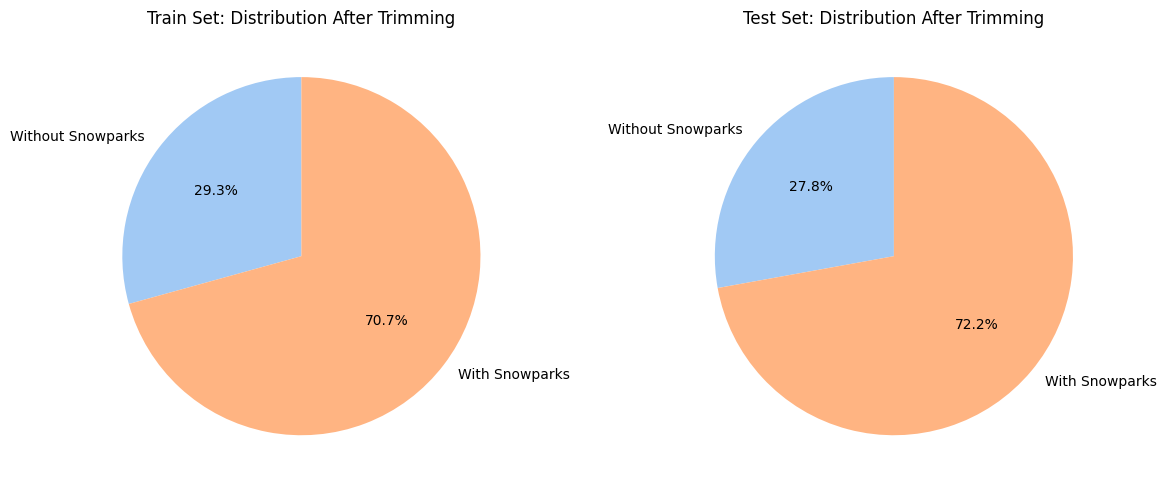

In [394]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Train set
counts_train = T_train.value_counts().sort_index()
labels_names = {1: 'With Snowparks', 0: 'Without Snowparks'}
labels_train = [labels_names[val] for val in counts_train.index]
axes[0].pie(counts_train, labels=labels_train, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
axes[0].set_title("Train Set: Distribution After Trimming")

# Test set
counts_test = T_test.value_counts().sort_index()
labels_test = [labels_names[val] for val in counts_test.index]
axes[1].pie(counts_test, labels=labels_test, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
axes[1].set_title("Test Set: Distribution After Trimming")

plt.tight_layout()
plt.show()

## Consistency and Ignorability are explain in the report

# Causal Inference methods

### Regular Propensity model (to check overlap and trimm)

In [89]:
confounders = ['Intermediate slopes', 'Longitude', 'Summer skiing_numeric', 'Lowest point', 'Chair lifts', 'Lift capacity', 'Total slopes', 'Highest point', 'Country_numeric', 'expense_score']
# confounders += ['Rating'] # manual Robustness check
y = merged[Y_COL] 
X = merged[confounders]
T = merged[T_COL]
X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(X, T, y, test_size=0.2, random_state=71) # 42 also works 24, for 2025 for confounders orig 42

propensity_model = LogisticRegressionCV(cv=5, random_state=42)
propensity_model.fit(X_train, T_train)
# Predict probabilities on the test set
T_prob_train = propensity_model.predict_proba(X_train)[:,1]
T_prob_test = propensity_model.predict_proba(X_test)[:,1] # Probabilities for the positive class


In [90]:
# Brier score, 0 is the perfect score
brier_score = brier_score_loss(T_test, T_prob_test)
print(f'Brier Score: {brier_score}')

Brier Score: 0.14284302072240437


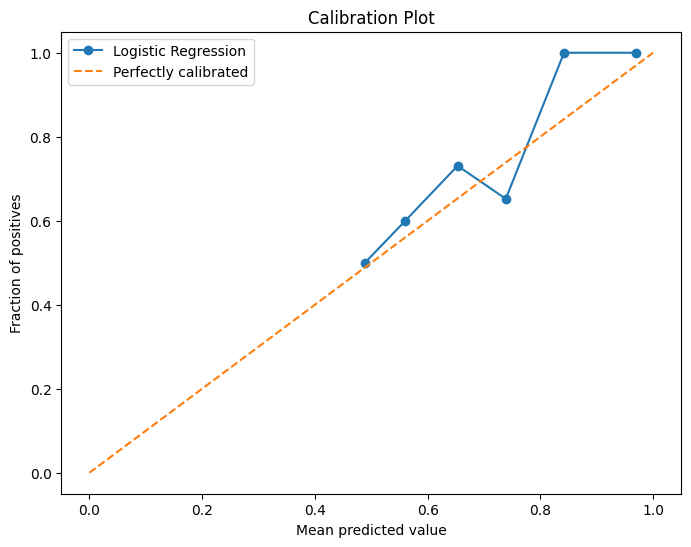

In [91]:
# Calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(T_test, T_prob_test, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.title('Calibration Plot')
plt.legend()
plt.show()

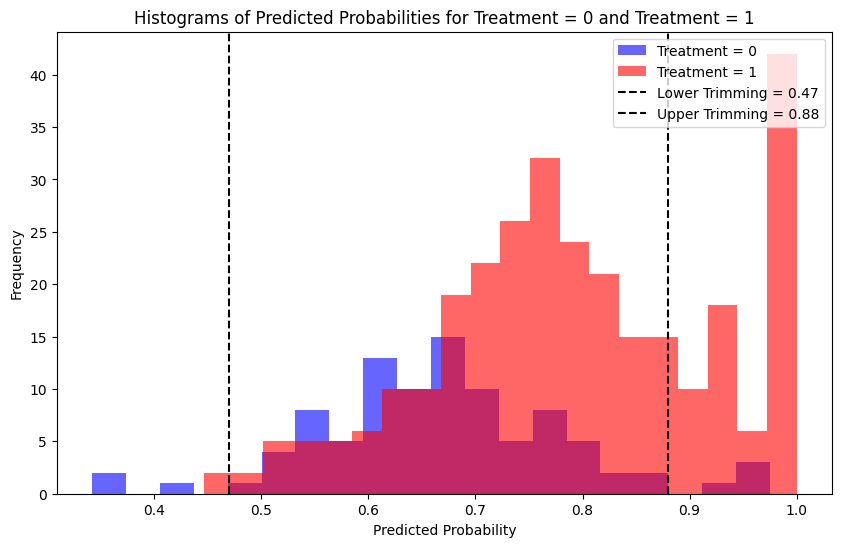

In [93]:
prob_treatment_0 = T_prob_train[T_train == 0]
prob_treatment_1 = T_prob_train[T_train == 1]

plt.figure(figsize=(10, 6))
plt.hist(prob_treatment_0, bins=20, alpha=0.6, label='Treatment = 0', color='blue')
plt.hist(prob_treatment_1, bins=20, alpha=0.6, label='Treatment = 1', color='red')
# plt.axvline(x=0.4, color='black', linestyle='--', label='Lower Trimming = 0.4')
# plt.axvline(x=0.98, color='black', linestyle='--', label='Upper Trimming = 0.98')
plt.axvline(x=0.47, color='black', linestyle='--', label='Lower Trimming = 0.47')
plt.axvline(x=0.88, color='black', linestyle='--', label='Upper Trimming = 0.88')

plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Histograms of Predicted Probabilities for Treatment = 0 and Treatment = 1')
plt.legend(loc='upper right')
plt.show()

In [94]:
# low_lim = 0.465 # Manual robustness check
# up_lim = 0.98
low_lim = 0.47 
up_lim = 0.88

if ROBUSTNESS:
    low_lim = 0.44 # Manual robustness check
    up_lim = 0.89

print('Participants removed from train set due to lack of lower overlap: {}'.format(X_train[T_prob_train < low_lim].shape[0]))
print('Participants removed from train set due to lack of upper overlap: {}'.format(X_train[T_prob_train > up_lim].shape[0]))
print('Participants removed from test set due to lack of lower overlap: {}'.format(X_test[T_prob_test < low_lim].shape[0]))
print('Participants removed from train set due to lack of upper overlap: {}'.format(X_test[T_prob_test > up_lim].shape[0]))


Participants removed from train set due to lack of lower overlap: 5
Participants removed from train set due to lack of upper overlap: 84
Participants removed from test set due to lack of lower overlap: 0
Participants removed from train set due to lack of upper overlap: 21


In [68]:
X_train = X_train[(T_prob_train >= low_lim) & (T_prob_train <= up_lim)]
T_train = T_train[(T_prob_train >= low_lim) & (T_prob_train <= up_lim)]
y_train = y_train[(T_prob_train >= low_lim) & (T_prob_train <= up_lim)]
X_test = X_test[(T_prob_test >= low_lim) & (T_prob_test <= up_lim)]
T_test = T_test[(T_prob_test >= low_lim) & (T_prob_test <= up_lim)]
y_test = y_test[(T_prob_test >= low_lim) & (T_prob_test <= up_lim)]

### S-learner and T-learner


In [69]:
bootstrap_sample_size = 1000
alpha = 0.05

s_learner_model_train_data = pd.concat([X_train, T_train], axis=1)
s_learner_outcome_model = LinearRegression()

s_learner_model_test_treatment1 = X_test.assign(Snowparks_numeric=1)
s_learner_model_test_treatment0 = X_test.assign(Snowparks_numeric=0)


np.random.seed(42)
ate_estimates = []
# Bootstrap sampling and model fitting
for i in range(bootstrap_sample_size):
    # Generate bootstrap indices
    bootstrap_indices = np.random.choice(s_learner_model_train_data.index,
                                         size=s_learner_model_train_data.shape[0],
                                         replace=True)
    # Create the bootstrap sample using the indices
    X_train_resampled = s_learner_model_train_data.loc[bootstrap_indices]
    y_train_resampled = y_train.loc[bootstrap_indices]
    s_learner_outcome_model.fit(X_train_resampled, y_train_resampled)
    # Predict the two potential outcomes and calculate ATE
    y1_pred = s_learner_outcome_model.predict(s_learner_model_test_treatment1)
    y0_pred = s_learner_outcome_model.predict(s_learner_model_test_treatment0)
    ate_estimate = np.mean(y1_pred - y0_pred)
    ate_estimates.append(ate_estimate)

# Convert the list of estimates into a numpy array
s_bootstrap_estimates = np.array(ate_estimates)

# Calculate the lower and upper percentiles to get the CI
s_ci = np.percentile(s_bootstrap_estimates, [100 * alpha / 2, 100 * (1 - alpha / 2)], axis=0)

# Print the confidence interval (for example, for the first prediction)
print(f"95% Confidence Interval: Lower = {s_ci[0]}, Upper = {s_ci[1]}")

95% Confidence Interval: Lower = -1.6906995415586135, Upper = 5.029400956639599


In [101]:
s_bootstrap_estimates.mean()

In [70]:
bootstrap_sample_size = 1000
alpha = 0.05

t_learner_model_train_data = deepcopy(X_train) # notice that T is not included in learning
t_learner_outcome_model1 = LinearRegression()
t_learner_outcome_model0 = LinearRegression()

ate_estimates = []
# Bootstrap sampling and model fitting
for i in range(bootstrap_sample_size):
    # Generate bootstrap indices
    bootstrap_indices = np.random.choice(t_learner_model_train_data.index,
                                         size=t_learner_model_train_data.shape[0],
                                         replace=True)
    # Create the bootstrap sample using the indices
    X_train_resampled = t_learner_model_train_data.loc[bootstrap_indices]
    T_train_resampled = T_train.loc[bootstrap_indices]
    y_train_resampled = y_train.loc[bootstrap_indices]
    
    # train separate model on treatment=1 data
    X_train1_resampled = X_train_resampled[T_train_resampled == 1]
    y_train1_resampled = y_train_resampled[T_train_resampled == 1]
    t_learner_outcome_model1.fit(X_train1_resampled, y_train1_resampled)
    # train separate model on treatment=0 data
    X_train0_resampled = X_train_resampled[T_train_resampled == 0]
    y_train0_resampled = y_train_resampled[T_train_resampled == 0]
    t_learner_outcome_model0.fit(X_train0_resampled, y_train0_resampled)
    
    # Predict the two potential outcomes and calculate ATE
    y1_pred = t_learner_outcome_model1.predict(X_test)
    y0_pred = t_learner_outcome_model0.predict(X_test)
    ate_estimate = np.mean(y1_pred - y0_pred)
    ate_estimates.append(ate_estimate)

# Convert the list of estimates into a numpy array
t_bootstrap_estimates = np.array(ate_estimates)

# Calculate the lower and upper percentiles to get the CI
t_ci = np.percentile(t_bootstrap_estimates, [100 * alpha / 2, 100 * (1 - alpha / 2)], axis=0)

# Print the confidence interval (for example, for the first prediction)
print(f"95% Confidence Interval: Lower = {t_ci[0]}, Upper = {t_ci[1]}")

95% Confidence Interval: Lower = -3.689309122927552, Upper = 5.032464344364989


In [102]:
t_bootstrap_estimates.mean()

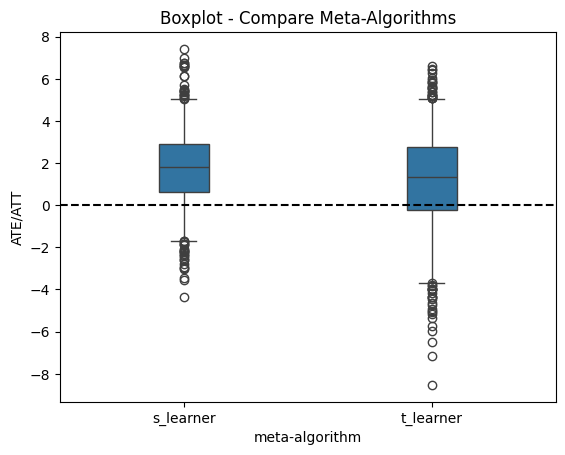

In [71]:
df = pd.DataFrame({'s_learner': s_bootstrap_estimates, 't_learner': t_bootstrap_estimates})
df_melt = df.melt()
df_melt.columns = ['meta-algorithm', 'ATE/ATT']
sns.boxplot(x='meta-algorithm', y='ATE/ATT', data=df_melt, width=0.2, whis=[2.5, 97.5])
plt.title('Boxplot - Compare Meta-Algorithms')
plt.axhline(y=0, linestyle='--', color='black')
plt.show()

### IPW

In [72]:
test_data = pd.concat([X_test, T_test, y_test], axis=1)
# bootstrap_sample_size = 1000
bootstrap_sample_size = 200
alpha = 0.05
np.random.seed(42)
ate_estimates = []

IPW_model = LogisticRegressionCV(cv=5, random_state=42)
# IPW_model = LogisticRegression(max_iter=1000, random_state=42)

# Bootstrap sampling and model fitting
for i in range(bootstrap_sample_size):
    # Generate bootstrap indices
    bootstrap_indices = np.random.choice(X_train.index,
                                         size=X_train.shape[0],
                                         replace=True)
    # Create the bootstrap sample using the indices
    X_train_resampled = X_train.loc[bootstrap_indices]
    T_train_resampled = T_train.loc[bootstrap_indices]
    IPW_model.fit(X_train_resampled, T_train_resampled)
    # get propensity on test
    temp_test_data = deepcopy(test_data)
    temp_test_data['propensity'] = IPW_model.predict_proba(temp_test_data[confounders])[:,1]
    y1_weighted_estimate = np.sum(((temp_test_data[T_COL] == 1).astype(int) * temp_test_data[Y_COL]) / temp_test_data['propensity']) / np.sum(temp_test_data[T_COL] == 1)
    y0_weighted_estimate = np.sum(((temp_test_data[T_COL] == 0).astype(int) * temp_test_data[Y_COL]) / (1 - temp_test_data['propensity'])) / np.sum(temp_test_data[T_COL] == 0)
    ate_estimate = y1_weighted_estimate - y0_weighted_estimate
    ate_estimates.append(ate_estimate)

# Convert the list of estimates into a numpy array
ipw_bootstrap_estimates = np.array(ate_estimates)

# Calculate the lower and upper percentiles to get the CI
ipw_ci = np.percentile(ipw_bootstrap_estimates, [100 * alpha / 2, 100 * (1 - alpha / 2)], axis=0)

# Print the confidence interval (for example, for the first prediction)
print(f"95% Confidence Interval: Lower = {ipw_ci[0]}, Upper = {ipw_ci[1]}")

95% Confidence Interval: Lower = -130.69057479277976, Upper = -51.468116717978454


פה נראלי סתם המודל עצמו כשל ולכן השיטה יצאה עם הטייה כל כך גדולה

Possibly that this model have failed because of poor callibration of propensity scores. 

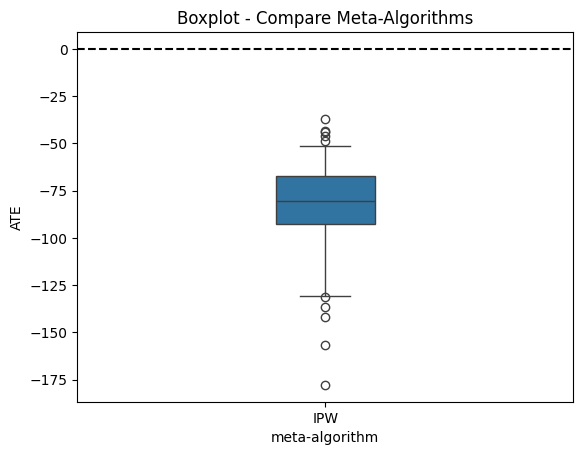

In [73]:
df_IPW = pd.DataFrame({'IPW': ipw_bootstrap_estimates}).melt()
df_IPW.columns = ['meta-algorithm', 'ATE']
df_filtered = df_IPW[df_IPW['ATE'] >= - 2000]

# sns.boxplot(x='meta-algorithm', y='ATE', data=df_filtered, width=0.2, whis=[2.5, 97.5])
sns.boxplot(x='meta-algorithm', y='ATE', data=df_IPW, width=0.2, whis=[2.5, 97.5])
plt.title('Boxplot - Compare Meta-Algorithms')
plt.axhline(y=0, linestyle='--', color='black')
plt.show()

### DR

In [74]:
def dr_estimator(row, potential_outcome):
    estimated_outcome = row['y1_estimate'] if potential_outcome == 1 else row['y0_estimate']
    if row[T_COL] == potential_outcome:
        estimated_propensity = row['propensity'] if potential_outcome == 1 else 1 - row['propensity']
        weighted_error = (row[Y_COL] - estimated_outcome)/ estimated_propensity
        return estimated_outcome + weighted_error
    else:
        return estimated_outcome

T learner DR

In [75]:
# bootstrap_sample_size = 1000
bootstrap_sample_size = 200
alpha = 0.05

t_learner_model_train_data = deepcopy(X_train) # notice that T is not included in learning
t_learner_outcome_model1 = LinearRegression()
t_learner_outcome_model0 = LinearRegression()
ate_estimates = []
# Bootstrap sampling and model fitting
for i in range(bootstrap_sample_size):
    # Generate bootstrap indices
    bootstrap_indices = np.random.choice(t_learner_model_train_data.index,
                                         size=t_learner_model_train_data.shape[0],
                                         replace=True)
    # Create the bootstrap sample using the indices
    X_train_resampled = t_learner_model_train_data.loc[bootstrap_indices]
    T_train_resampled = T_train.loc[bootstrap_indices]
    y_train_resampled = y_train.loc[bootstrap_indices]

    # train separate model on treatment=1 data
    X_train1_resampled = X_train_resampled[T_train_resampled == 1]
    y_train1_resampled = y_train_resampled[T_train_resampled == 1]
    t_learner_outcome_model1.fit(X_train1_resampled, y_train1_resampled)
    # train separate model on treatment=0 data
    X_train0_resampled = X_train_resampled[T_train_resampled == 0]
    y_train0_resampled = y_train_resampled[T_train_resampled == 0]
    t_learner_outcome_model0.fit(X_train0_resampled, y_train0_resampled)

    # fit propensity model
    IPW_model.fit(X_train_resampled, T_train_resampled)
    # get propensity on test
    temp_test_data = deepcopy(test_data)
    temp_test_data['propensity'] = IPW_model.predict_proba(temp_test_data[confounders])[:, 1]
    temp_test_data['y1_estimate'] = t_learner_outcome_model1.predict(X_test)
    temp_test_data['y0_estimate'] = t_learner_outcome_model0.predict(X_test)
    temp_test_data['dr1_estimate'] = temp_test_data.apply(lambda x: dr_estimator(x, 1), axis=1)
    temp_test_data['dr0_estimate'] = temp_test_data.apply(lambda x: dr_estimator(x, 0), axis=1)
    ate_estimate = np.mean(temp_test_data['dr1_estimate'] - temp_test_data['dr0_estimate'])
    ate_estimates.append(ate_estimate)

# Convert the list of estimates into a numpy array
dr_bootstrap_estimates = np.array(ate_estimates)

# Calculate the lower and upper percentiles to get the CI
dr_ci = np.percentile(dr_bootstrap_estimates, [100 * alpha / 2, 100 * (1 - alpha / 2)], axis=0)

# Print the confidence interval (for example, for the first prediction)
print(f"95% Confidence Interval: Lower = {dr_ci[0]}, Upper = {dr_ci[1]}")

95% Confidence Interval: Lower = -8.263337431246503, Upper = -0.46152856804221876


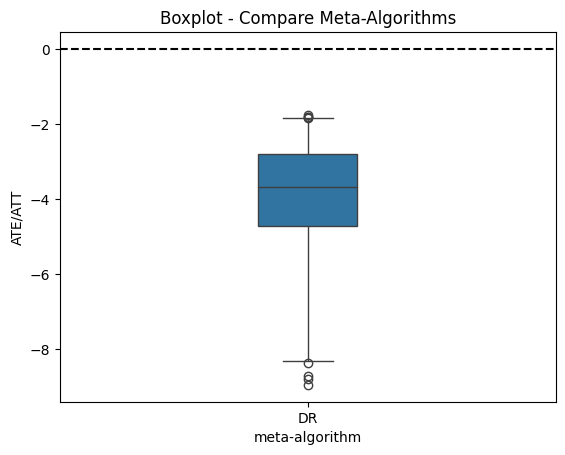

In [76]:
bootstrap_dict = {'DR': dr_bootstrap_estimates}
df_DR = pd.DataFrame(bootstrap_dict).melt()
df_DR.columns = ['meta-algorithm', 'ATE/ATT']
lower, upper = df_DR['ATE/ATT'].quantile([0.00, 0.8])
df_filtered = df_DR[(df_DR['ATE/ATT'] >= lower) & (df_DR['ATE/ATT'] <= upper)]

sns.boxplot(x='meta-algorithm', y='ATE/ATT', data=df_filtered, width=0.2, whis=[2.5, 97.5])
plt.title('Boxplot - Compare Meta-Algorithms')
plt.axhline(y=0, linestyle='--', color='black')
plt.show()

### Matching

In [77]:
propensity_train_data = pd.concat([X_train, T_train, y_train], axis=1)
propensity_test_data = pd.concat([X_test, T_test, y_test], axis=1)
trimmed_data = pd.concat([propensity_train_data, propensity_test_data])
trimmed_data.describe()

,Intermediate slopes,Longitude,Summer skiing_numeric,Lowest point,Chair lifts,Lift capacity,Total slopes,Highest point,Country_numeric,expense_score,Snowparks_numeric,Price
count,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000
mean,23.515873,-11.014914,0.047619,1208.939153,5.653439,16425.783069,52.648148,2046.505291,8.113757,66.683069,0.714286,47.547619
std,18.484089,60.719243,0.213241,615.620029,3.989908,8804.127273,37.291034,764.909382,6.592357,16.302765,0.452353,20.255899
min,0.000000,-149.740657,0.000000,36.000000,0.000000,0.000000,2.000000,492.000000,0.000000,25.900000,0.000000,14.000000
25%,10.000000,-4.599060,0.000000,800.000000,3.000000,10110.000000,25.000000,1442.000000,5.000000,62.200000,0.000000,34.250000
50%,20.000000,8.120514,0.000000,1116.500000,5.000000,15403.000000,44.000000,2045.000000,7.000000,64.800000,1.000000,44.000000
75%,32.000000,12.418347,0.000000,1504.000000,8.000000,22430.000000,70.000000,2553.750000,10.000000,70.400000,1.000000,54.000000
max,111.000000,176.876668,1.000000,3286.000000,22.000000,39750.000000,250.000000,3871.000000,36.000000,101.100000,1.000000,124.000000


In [78]:
all_cols = confounders
# categorical_cols = ['Continent_numeric', 'Child friendly_numeric', 'Nightskiing_numeric','Summer skiing_numeric']
categorical_cols = ['Summer skiing_numeric']
table1_before = TableOne(trimmed_data, columns=all_cols, categorical=categorical_cols, groupby='Snowparks_numeric', nonnormal=[], pval=False, smd=True)
print(table1_before.tabulate(tablefmt="fancy_grid"))

╒════════════════════════════════╤════╤═══════════╤══════════════════╤══════════════════╤══════════════════╤═════════════╕
│                                │    │ Missing   │ Overall          │ 0                │ 1                │ SMD (0,1)   │
╞════════════════════════════════╪════╪═══════════╪══════════════════╪══════════════════╪══════════════════╪═════════════╡
│ n                              │    │           │ 378              │ 108              │ 270              │             │
├────────────────────────────────┼────┼───────────┼──────────────────┼──────────────────┼──────────────────┼─────────────┤
│ Intermediate slopes, mean (SD) │    │ 0         │ 23.5 (18.5)      │ 15.5 (13.9)      │ 26.7 (19.1)      │ 0.668       │
├────────────────────────────────┼────┼───────────┼──────────────────┼──────────────────┼──────────────────┼─────────────┤
│ Longitude, mean (SD)           │    │ 0         │ -11.0 (60.7)     │ -6.0 (61.1)      │ -13.0 (60.5)     │ -0.115      │
├───────────────

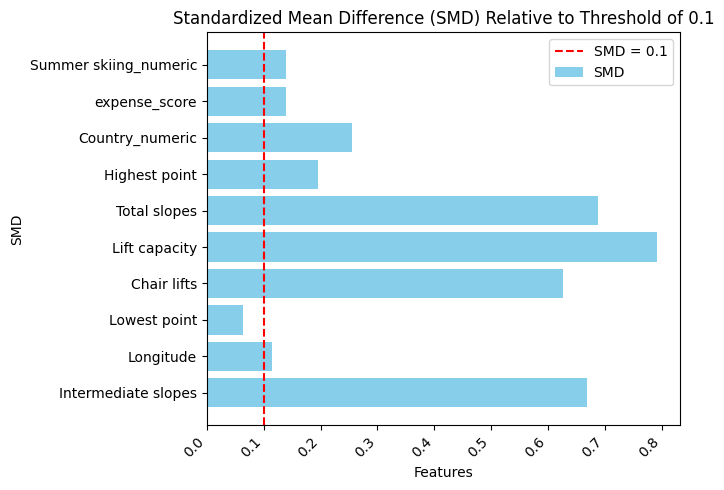

In [79]:
plt.figure(figsize=(7, 5))
plt.barh(table1_before.smd_table.index, abs(table1_before.smd_table.values).flatten(), color='skyblue', label='SMD')

# SMD <= 0.1 is the convention for acceptable, like p-value <= 0.05
plt.axvline(x=0.1, color='r', linestyle='--', label='SMD = 0.1')
plt.xlabel('Features')
plt.ylabel('SMD')
plt.title('Standardized Mean Difference (SMD) Relative to Threshold of 0.1')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [80]:
standard_scaler = StandardScaler().fit(trimmed_data[confounders])
standardized_data = deepcopy(trimmed_data)
standardized_data[confounders] = standard_scaler.transform(standardized_data[confounders])
standardized_data_treat1 = standardized_data.query('Snowparks_numeric == 1').reset_index().drop(columns=['index'])
standardized_data_treat0 = standardized_data.query('Snowparks_numeric == 0').reset_index().drop(columns=['index'])

In [81]:
nn = NearestNeighbors(algorithm='brute', metric='euclidean', n_neighbors=1) 
# nn = NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=1) # For ROBUSTNBESS

# Fit on treatment=1 group, find nearest neighbor for each treatment=0 row
nn.fit(standardized_data_treat1[confounders])
distance, indices = nn.kneighbors(standardized_data_treat0[confounders])
standardized_data_treat0['matched_treat1'] = indices.flatten()
matched_data = standardized_data_treat0.merge(
    standardized_data_treat1, left_on='matched_treat1', right_index=True, how='left', suffixes=('_treat0', '_treat1')
)

In [82]:
print("Debug info:")
print(f"match_confounders: {confounders}")
print(f"matched_data shape: {matched_data.shape}")
print(f"matched_data columns: {list(matched_data.columns)}")

# Find columns with _treat0 and _treat1 suffixes for confounders
treat1_confounder_cols = [f"{conf}_treat1" for conf in confounders if f"{conf}_treat1" in matched_data.columns]
treat0_confounder_cols = [f"{conf}_treat0" for conf in confounders if f"{conf}_treat0" in matched_data.columns]

# Also add the treatment variable columns
if 'Snowparks_numeric_treat1' in matched_data.columns:
    treat1_confounder_cols.append('Snowparks_numeric_treat1')
if 'Snowparks_numeric_treat0' in matched_data.columns:
    treat0_confounder_cols.append('Snowparks_numeric_treat0')

print(f"treat1_confounder_cols: {treat1_confounder_cols}")
print(f"treat0_confounder_cols: {treat0_confounder_cols}")

# Create treatment group 1 data (rename _treat1 columns to original names)
treat1_data = matched_data[treat1_confounder_cols].copy()
treat1_rename_dict = {}
for conf in confounders:
    if f"{conf}_treat1" in matched_data.columns:
        treat1_rename_dict[f"{conf}_treat1"] = conf
if 'Snowparks_numeric_treat1' in matched_data.columns:
    treat1_rename_dict['Snowparks_numeric_treat1'] = 'Snowparks_numeric'
treat1_data = treat1_data.rename(columns=treat1_rename_dict)

# Create treatment group 0 data (rename _treat0 columns to original names)  
treat0_data = matched_data[treat0_confounder_cols].copy()
treat0_rename_dict = {}
for conf in confounders:
    if f"{conf}_treat0" in matched_data.columns:
        treat0_rename_dict[f"{conf}_treat0"] = conf
if 'Snowparks_numeric_treat0' in matched_data.columns:
    treat0_rename_dict['Snowparks_numeric_treat0'] = 'Snowparks_numeric'
treat0_data = treat0_data.rename(columns=treat0_rename_dict)

# Combine both datasets
matching_df_long = pd.concat([treat1_data, treat0_data], axis=0, ignore_index=True)

print(f"\nAfter combining:")
print(f"matching_df_long shape: {matching_df_long.shape}")
print(f"matching_df_long columns: {list(matching_df_long.columns)}")

# Check for missing values
# missing_values = matching_df_long.isnull().sum()
# print(f"\nMissing values per column:")
# print(missing_values[missing_values > 0])

# Get only the confounders that exist in the final dataset
available_confounders = [conf for conf in confounders if conf in matching_df_long.columns]
# print(f"\nAvailable confounders for TableOne: {available_confounders}")

table1 = TableOne(matching_df_long, columns=available_confounders, groupby='Snowparks_numeric', nonnormal=[], pval=False, smd=True)
print(table1.tabulate(tablefmt="fancy_grid"))


Debug info:
match_confounders: ['Intermediate slopes', 'Longitude', 'Summer skiing_numeric', 'Lowest point', 'Chair lifts', 'Lift capacity', 'Total slopes', 'Highest point', 'Country_numeric', 'expense_score']
matched_data shape: (108, 25)
matched_data columns: ['Intermediate slopes_treat0', 'Longitude_treat0', 'Summer skiing_numeric_treat0', 'Lowest point_treat0', 'Chair lifts_treat0', 'Lift capacity_treat0', 'Total slopes_treat0', 'Highest point_treat0', 'Country_numeric_treat0', 'expense_score_treat0', 'Snowparks_numeric_treat0', 'Price_treat0', 'matched_treat1', 'Intermediate slopes_treat1', 'Longitude_treat1', 'Summer skiing_numeric_treat1', 'Lowest point_treat1', 'Chair lifts_treat1', 'Lift capacity_treat1', 'Total slopes_treat1', 'Highest point_treat1', 'Country_numeric_treat1', 'expense_score_treat1', 'Snowparks_numeric_treat1', 'Price_treat1']
treat1_confounder_cols: ['Intermediate slopes_treat1', 'Longitude_treat1', 'Summer skiing_numeric_treat1', 'Lowest point_treat1', 'Chai

In [83]:
np.mean(matched_data['Price_treat1'] - matched_data['Price_treat0'])

np.float64(-0.37962962962962965)

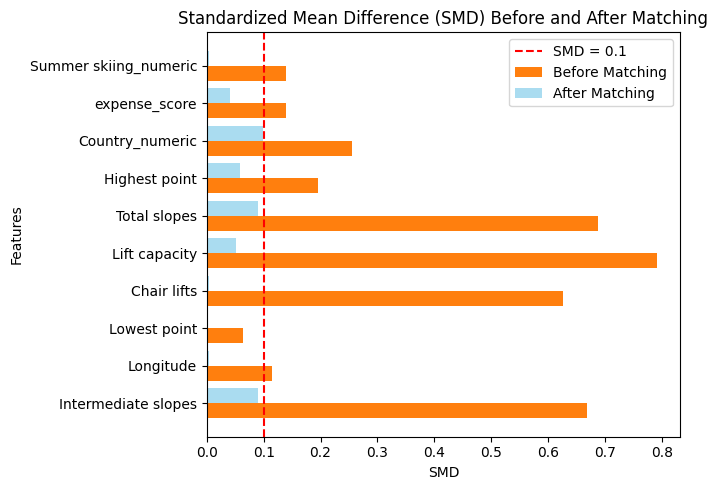

In [84]:
features = table1_before.smd_table.index
smd_before = abs(table1_before.smd_table.values).flatten()
smd_after = abs(table1.smd_table.values).flatten()

y = np.arange(len(features))
bar_height = 0.4  # half the default

plt.figure(figsize=(7, 5))
plt.barh(y - bar_height/2, smd_before, height=bar_height, color='#ff7f0e', label='Before Matching')
plt.barh(y + bar_height/2, smd_after, height=bar_height, color='skyblue', label='After Matching', alpha=0.7)

plt.axvline(x=0.1, color='r', linestyle='--', label='SMD = 0.1')
plt.xlabel('SMD')
plt.yticks(y, features)
plt.ylabel('Features')
plt.title('Standardized Mean Difference (SMD) Before and After Matching')
plt.legend()
plt.tight_layout()
plt.show()

In [85]:
bootstrap_sample_size = 1000
alpha = 0.05
np.random.seed(2025)
att_estimates = []
# Bootstrap sampling and model fitting
for i in range(bootstrap_sample_size):
    # Generate bootstrap indices
    bootstrap_indices = np.random.choice(standardized_data.index,
                                         size=standardized_data.shape[0],
                                         replace=True)
    bootstrap_standardized_data = standardized_data.loc[bootstrap_indices]
    standardized_data_treat1 = bootstrap_standardized_data.query('Snowparks_numeric == 1').reset_index().drop(columns=['index'])
    standardized_data_treat0 = bootstrap_standardized_data.query('Snowparks_numeric == 0').reset_index().drop(columns=['index'])
    nn = NearestNeighbors(algorithm='brute', metric='euclidean', n_neighbors=1)
    distance, standardized_data_treat1['matched_treat0'] = nn.fit(standardized_data_treat0[confounders]).kneighbors(standardized_data_treat1[confounders])
    matched_data = standardized_data_treat1.merge(standardized_data_treat0, left_on='matched_treat0', right_index=True, how='left', suffixes=('_treat1', '_treat0'))
    att_estimate = np.mean(matched_data['Price_treat1'] - matched_data['Price_treat0'])
    att_estimates.append(att_estimate)

# Convert the list of estimates into a numpy array
matching_bootstrap_estimates = np.array(att_estimates)

# Calculate the lower and upper percentiles to get the CI
matching_ci = np.percentile(matching_bootstrap_estimates, [100 * alpha / 2, 100 * (1 - alpha / 2)], axis=0)

# Print the confidence interval (for example, for the first prediction)
print(f"95% Confidence Interval: Lower = {matching_ci[0]}, Upper = {matching_ci[1]}")

95% Confidence Interval: Lower = 0.47500422154677474, Upper = 7.446600037073653


In [86]:
matching_bootstrap_estimates.mean()

np.float64(3.8550413029266064)

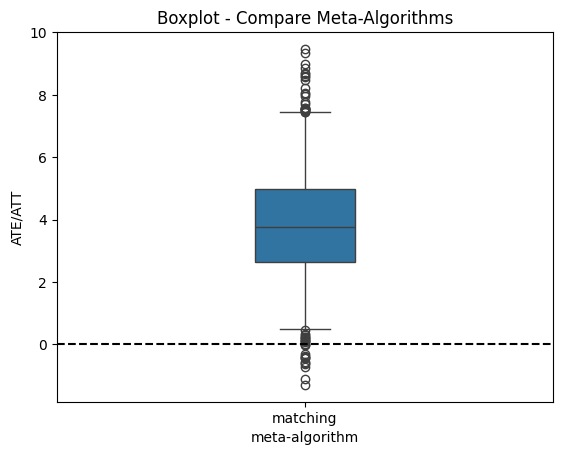

In [87]:
df_match = pd.DataFrame({'matching': matching_bootstrap_estimates}).melt()
df_match.columns = ['meta-algorithm', 'ATE/ATT']
# df = pd.concat([df_melt, df_match],  ignore_index=True)
# sns.boxplot(x='meta-algorithm', y='ATE/ATT', data=df, width=0.2, whis=[2.5, 97.5])
sns.boxplot(x='meta-algorithm', y='ATE/ATT', data=df_match, width=0.2, whis=[2.5, 97.5])
plt.title('Boxplot - Compare Meta-Algorithms')
plt.axhline(y=0, linestyle='--', color='black')
plt.show()

# Robustness

We used ROBUSTNESS flag to run robustness checks that connected to different types of cleaning, usage of 'Rating" etc.

To use robustness techniques set ROBUSTNESS = True in `Imports` section 

In some parts (for example in trimming) - we did it manually - we commented this line for final submission

In additional we used refutation techniques, to test the robustness of our findings

In [95]:
# %pip install dowhy
from dowhy import CausalModel

In [96]:
model = CausalModel(
    data=merged,
    treatment=T_COL,
    outcome=Y_COL,
    common_causes=confounders
)

identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                     ↪
────────────────────(E[Price|Intermediate slopes,Highest point,Total slopes,Ch ↪
d[Snowparks_numeric]                                                           ↪

↪                                                                              ↪
↪ air lifts,expense_score,Country_numeric,Summer skiing_numeric,Lift capacity, ↪
↪                                                                              ↪

↪                         
↪ Longitude,Lowest point])
↪                         
Estimand assumption 1, Unconfoundedness: If U→{Snowparks_numeric} and U→Price then P(Price|Snowparks_numeric,Intermediate slopes,Highest point,Total slopes,Chair lifts,expense_score,Country_numeric,Summer skiing_numeric,Lift capacity,Longitude,Lowest point,U) = P(Price|Snowparks_numeric,Intermediate slopes,Highest point,Total slopes,

In [97]:
causal_estimate_linear = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression", 
    test_significance=True
)
print("Linear regression estimate:", causal_estimate_linear.value)

causal_estimate_pstrat = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_stratification",
    test_significance=True
)
print("Propensity stratification estimate:", causal_estimate_pstrat.value)

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': True, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
Linear regression estimate: 4.851709502023219
propensity_score_stratification
Propensity stratification estimate: 3.587821591269865


In [ ]:
res_placebo = model.refute_estimate(
    identified_estimand,
    causal_estimate_linear,
    method_name="placebo_treatment_refuter")
print(res_placebo)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

In [108]:
res_dummy_outcome = model.refute_estimate(
    identified_estimand,
    causal_estimate_linear,
    method_name="dummy_outcome_refuter"
)

# If it's a list, print each nicely
for r in res_dummy_outcome:
    print(r)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

In [124]:
# Subset refuter
subset_ref = model.refute_estimate(identified_estimand, causal_estimate_linear,
                            method_name="data_subset_refuter", subset_fraction=0.5)
print(subset_ref)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

## Saving results to df to add in the report

In [132]:
res_dict = {"estimated_effect": [res_placebo.estimated_effect, res_dummy_outcome[0].estimated_effect ,subset_ref.estimated_effect],
"new_effect": [res_placebo.new_effect, res_dummy_outcome[0].new_effect, subset_ref.new_effect ],
"p_value": [res_placebo.refutation_result.get("p_value", None), res_dummy_outcome[0].refutation_result.get("p_value", None), subset_ref.refutation_result.get("p_value", None)]}


robustness_df = pd.DataFrame(res_dict, index = ['placebo', 'dummy','subset'])
robustness_df.head()

,estimated_effect,new_effect,p_value
placebo,4.85171,-5.649525e-11,0.00
dummy,0.00000,-4.605350e-03,0.98
subset,4.85171,4.758036e+00,0.96
